# 🛠️ MLflow Hands-On

🎯 **Our goal** is to demonstrate how to integrate **MLflow** into a *machine learning* project, showcasing its role in tracking and managing experiments efficiently.

We'll start by **fitting an initial boosting model**, logging parameters, metrics, and artifacts. Then, we'll move on to **hyperparameter optimization using Optuna**, with the entire workflow tracked and versioned through MLflow.

---------------

🛒 **Dataset**
For this project, we used the **Wholesale Customers Data Set**, available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Wholesale+customers).

This dataset provides insights into customer spending habits across different product categories, making it a useful resource for unsupervised learning and clustering tasks.

## 📚 Importing libraries

In [ ]:
# Data Manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Modeling and Evaluation
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, 
    f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
)

# Optimization and Experiment Tracking
from mlflow.tracking import MlflowClient
import optuna
import mlflow

#  Utilities
import warnings
import json
import math
from datetime import datetime, timedelta

from sklearn.metrics import f1_score
import math

# Suppress Warnings
warnings.filterwarnings('ignore')

## 📥 Import dataset

In [2]:
df = pd.read_csv('Wholesale customers data.csv')
df.tail()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
435,1,3,29703,12051,16027,13135,182,2204
436,1,3,39228,1431,764,4510,93,2346
437,2,3,14531,15488,30243,437,14841,1867
438,1,3,10290,1981,2232,1038,168,2125
439,1,3,2787,1698,2510,65,477,52


## 🔍 Checking for missing values

In [3]:
df.isnull().sum()

Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64

## 🎯 Declare feature vector and target variable

In [4]:
X = df.drop('Channel', axis=1)

y = df['Channel']
y.head()

0    2
1    2
2    2
3    1
4    2
Name: Channel, dtype: int64

We can see that the \$y\$ labels currently contain the values \$1\$ and \$2\$. For simplicity and easier interpretation, we will convert them to \$0\$ and \$1\$ for further analysis.

In [5]:
y[y == 2] = 0
y[y == 1] = 1

Now, I will convert the dataset into an optimized data structure called **Dmatrix** that XGBoost supports and gives it acclaimed performance and efficiency gains

In [6]:
data_dmatrix = xgb.DMatrix(data=X,label=y)

## ✂️ Split data into separate training and test set

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 123)

## 🔧 Train the XGBoost Classifier

Now it's time to train our **XGBoost classifier**!
Before we begin, it’s important to understand the different types of parameters that XGBoost offers. These parameters control the model’s behavior, performance, and complexity.

There are **four main categories** of parameters you should know:


### ⚙️ General parameters

These define which **booster type** to use (e.g., tree-based or linear).
Common options include:

* `gbtree` – tree-based models (default)
* `gblinear` – linear models
* `dart` – tree-based models with dropout


### 🌲 Booster parameters

These depend on the selected booster type and control the training process of individual trees or models.


### 🎯 Learning task parameters

These define the **objective function** and the type of learning task (e.g., regression, classification, ranking).

### 💻 Command line parameters

These relate to the CLI (Command Line Interface) version of XGBoost, and aren’t usually needed when using the Python API.


## 🧠 Key Parameters to know

Here are some of the most important parameters you'll likely tune:

* **`learning_rate`** – Controls the step size shrinkage to prevent overfitting. Range: `[0, 1]`.
* **`max_depth`** – Maximum depth of a tree. Deeper trees can capture more complex patterns.
* **`subsample`** – Fraction of the training data to use for each tree. Lower values can help prevent overfitting.
* **`colsample_bytree`** – Fraction of features to use for each tree. Higher values may lead to overfitting.
* **`n_estimators`** – Number of boosting rounds (i.e., trees).
* **`objective`** – Specifies the learning task and the corresponding loss function:

  * `reg:squarederror` – for regression
  * `binary:logistic` – for binary classification (probability output)
  * `reg:logistic` – for classification with decision outputs


## 🛡️ Regularization parameters

XGBoost also offers regularization to reduce model complexity and avoid overfitting:

* **`gamma`** – Minimum loss reduction required to make a split. Higher values result in fewer splits.
* **`alpha`** – L1 regularization term on weights (Lasso). Encourages sparsity.
* **`lambda`** – L2 regularization term on weights (Ridge). Adds smoothness.

Even though we're using **trees as base learners**, XGBoost also supports linear models (`gblinear`) and dropout-based trees (`dart`) via the `booster` parameter.

---

Imagine you're a data scientist, and it's time to fine-tune your machine learning model. Fortunately, after some experimentation, you’ve found that the parameter combination below delivers a satisfactory performance for your classification task.


In [8]:
params = {
    # Target function for binary classification
    'objective': 'binary:logistic',

    # Evaluation metric
    'eval_metric': 'logloss',

    # Booster type (default is 'gbtree')
    'booster': 'gbtree',

    # Learning rate (step size shrinkage)
    'learning_rate': 0.1,

    # Maximum depth of each tree
    'max_depth': 3,

    # Subsample ratio of the training instances
    'subsample': 0.8,

    # Subsample ratio of columns for each tree
    'colsample_bytree': 0.8,

    # L2 regularization term on weights (Ridge)
    'lambda': 0.0,

    # L1 regularization term on weights (Lasso)
    'alpha': 1.0}

#------------------

# Instantiate the classifier
xgb_clf = XGBClassifier(**params)

# Fit the classifier to the training data
xgb_clf.fit(X_train, y_train)
print(xgb_clf)


XGBClassifier(alpha=1.0, base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None, lambda=0.0,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, ...)


## 🔮 Make Predictions with XGBoost Classifier

In [9]:
# make predictions on test data
y_pred = xgb_clf.predict(X_test)

## ✅ Check Accuracy Score

Accuracy:  0.9167
Precision: 0.9368
Recall:    0.9468
f1-Score:  0.9418
AUC:       0.9600


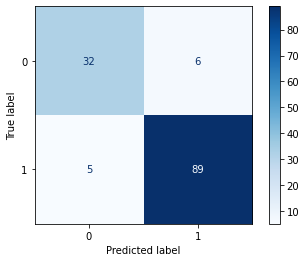

In [10]:
# Evaluate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:, 1])

# Print scores
print(f'Accuracy:  {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall:    {recall:.4f}')
print(f'f1-Score:  {f1:.4f}')
print(f'AUC:       {auc:.4f}')

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')

## 🔍 Feature importance with XGBoost

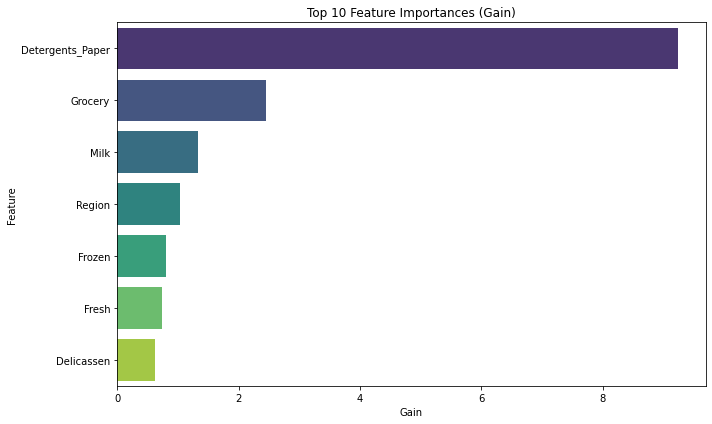

In [11]:
importances = xgb_clf.get_booster().get_score(importance_type='gain')

# Convert to DataFrame and sort
importance_df = pd.DataFrame({
    'Feature': list(importances.keys()),
    'Importance': list(importances.values())
}).sort_values(by='Importance', ascending=False)

# Optional: show only top N features
top_n = 10
importance_df = importance_df.head(top_n)

# Plot with seaborn
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')
plt.title(f"Top {top_n} Feature Importances (Gain)")
plt.xlabel("Gain")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


------------

📦 **Project Handoff to MLOps**

Now, imagine this is the final output of a data scientist's work. This project will be handed over to a machine learning engineer, who will be responsible for versioning the model using MLflow.

The engineer will set up experiment tracking, store the generated artifacts, monitor model performance metrics, and ensure the entire workflow is reproducible all as part of a well-structured MLOps pipeline.

🎯 **Next Step: Hyperparameter Optimization**

From this point on, we will perform hyperparameter optimization using Optuna. Meanwhile, MLflow will continue to log each experiment, allowing us to compare versions and easily identify the best set of parameters.


---------

## ⚙️ MLOps in Practice: Managing the Machine Learning Model Lifecycle

Now, we explore how **MLOps** practices help structure, automate, and scale the machine learning model lifecycle — from data preparation and model training to deployment, monitoring, and continuous improvement. We'll demonstrate how tools like **MLflow** can streamline this process and ensure reproducibility, traceability, and collaboration across teams.

## 🚀 Initializing the MLflow Server

To start the MLflow tracking server locally, follow the steps based on your environment:

---

### 🐍 **Using Anaconda**

1. Open the **Anaconda Command Prompt**  
2. Navigate to your project directory:

   ```bash
   cd your-project-path

3. Run the MLflow server:

   ```bash
   python -m mlflow server --host 127.0.0.1 --port 8282


### 💻 **Using VS Code**

1. Open the **terminal** in VS Code
2. Run the command below:

   ```bash
   py -m mlflow server --host 127.0.0.1 --port 8282

✅ Make sure you're using the same Python environment or kernel as the one used in your notebook or training script.

-----

🛰️  Now, let's define the address of the MLflow tracking server — that is, where the experiment logs (parameters, metrics, models, etc.) will be sent and stored.

In [12]:
mlflow.set_tracking_uri("http://127.0.0.1:8282")

Access the URL above from a new tab in your browser: [http://127.0.0.1:8282](http://127.0.0.1:8282)


## 📈 **Monitoring the Trained Model**

To properly monitor the performance of the trained model, we will generate a series of visualizations that will help us better understand how the model is behaving.

These plots will assist in:

* Evaluating predictive quality
* Identifying potential bias or imbalance
* Detecting signs of overfitting or underfitting
* Supporting model explainability and transparency

By visualizing key metrics and outputs, we can gain valuable insights that go beyond raw numbers and ensure the model remains reliable over time.

In [13]:
def plot_corr(df, target='Channel', save_path=None, top_n=None):
    '''
    Parameters:
    - df: pandas DataFrame containing the dataset
    - target: string, name of the target column
    - save_path: optional path to save the figure (as PNG)
    - top_n: optional, number of top features to display based on absolute correlation
    '''
    # Compute correlations with the target 
    corr = df.corr()[target].drop(target)
    corr = corr.reindex(corr.abs().sort_values().index)

    # Optionally show only top N correlated features
    if top_n:
        corr = corr.tail(top_n)

    # Set clean white style
    sns.set_style("white")
    fig, ax = plt.subplots(figsize=(10, 0.5 * len(corr) + 1))

    # Plot horizontal bars with elegant color
    bars = ax.barh(
        corr.index, corr.values,
        color="#4C72B0", edgecolor="black", height=0.6
    )

    # Add correlation values next to bars
    for bar in bars:
        width = bar.get_width()
        ax.text(
            x=width + 0.02 if width > 0 else width - 0.02,
            y=bar.get_y() + bar.get_height() / 2,
            s=f"{width:.2f}",
            va='center',
            ha='left' if width > 0 else 'right',
            fontsize=11)

    # Clean and minimal axes
    ax.set_title(f"Correlation with '{target}'", fontsize=16, pad=12)
    ax.set_xlabel("Correlation Coefficient", fontsize=13)
    ax.set_ylabel("")
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_color('#cccccc')
    ax.spines['bottom'].set_color('#cccccc')
    plt.grid(axis='x', linestyle='--', alpha=0.4)
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    plt.tight_layout()

    # Save figure if needed
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()


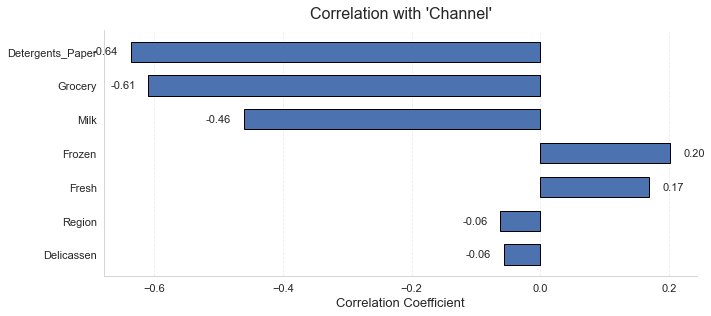

In [14]:
plot_corr(df)

In [15]:
def plot_confusion_matrix(y_true, y_pred, labels=None, save_path=None):
    '''
    Plots a styled confusion matrix with annotated counts.

    Parameters:
    - y_true: array-like, true target labels
    - y_pred: array-like, predicted labels
    - labels: optional list of label names (for axis ticks)
    - save_path: optional path to save the figure as PNG
    '''
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Set seaborn style
    sns.set_style("whitegrid", {
        "axes.facecolor": "#eaeaf2",
        "grid.linewidth": 1.2
    })

    # Create figure
    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot heatmap
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues",
        cbar=False, square=True, linewidths=0.5,
        xticklabels=labels if labels else "auto",
        yticklabels=labels if labels else "auto",
        ax=ax
    )

    # Titles and labels
    ax.set_title("Confusion Matrix", fontsize=16, pad=12)
    ax.set_xlabel("Predicted Labels", fontsize=13)
    ax.set_ylabel("True Labels", fontsize=13)
    ax.tick_params(axis='both', labelsize=12)

    # Adjust layout
    plt.tight_layout()

    # Save if path provided
    if save_path:
        plt.savefig(save_path, format="png", dpi=600)

    # Close and return figure
    plt.close(fig)
    return fig


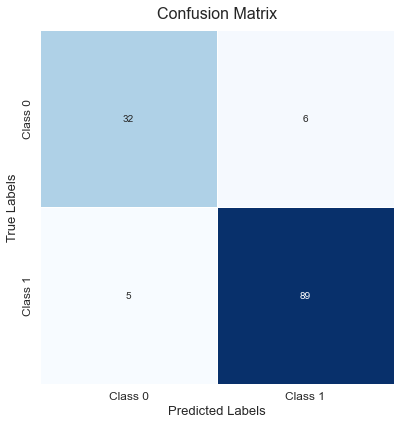

In [16]:
plot_confusion_matrix(y_test, y_pred, labels=['Class 0', 'Class 1'])

In [17]:
def plot_feature_importance(model, booster="gbtree", top_n=10, importance_type=None, save_path=None):
    '''
    Plots feature importance for a trained XGBoost model (either Booster or XGBClassifier).
    '''
    if importance_type is None:
        importance_type = "weight" if booster == "gblinear" else "gain"

    # Handle both Booster and XGBClassifier
    if hasattr(model, "get_booster"):
        booster_model = model.get_booster()
    else:
        booster_model = model  # assume it's already a Booster

    # Extract feature importances
    importances = booster_model.get_score(importance_type=importance_type)

    importance_df = pd.DataFrame({
        'Feature': list(importances.keys()),
        'Importance': list(importances.values())
    }).sort_values(by='Importance', ascending=False)

    if top_n:
        importance_df = importance_df.head(top_n)

    sns.set_style("white")
    plt.figure(figsize=(10, 6))
    sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')

    plt.title(f"Top {top_n} Feature Importances ({importance_type.title()})", fontsize=14)
    plt.xlabel(importance_type.title(), fontsize=12)
    plt.ylabel("Feature", fontsize=12)
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    plt.grid(axis='x', linestyle='--', alpha=0.3)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')

    fig = plt.gcf()
    plt.close()
    return fig


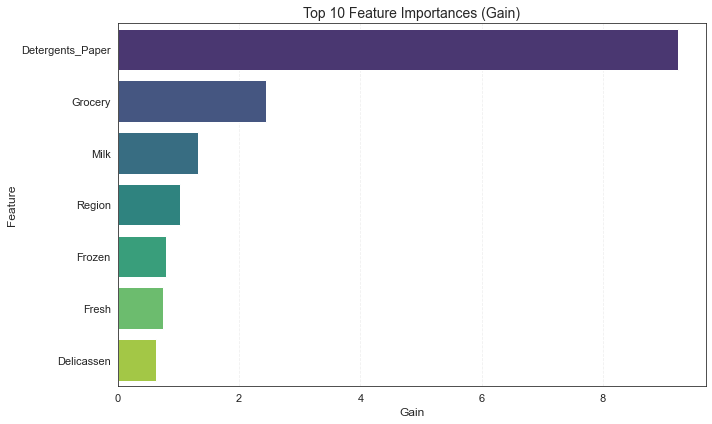

In [18]:
plot_feature_importance(xgb_clf, booster="gbtree", top_n=10, importance_type=None, save_path=None)

## 🧪 Creating the experiment in MLflow

In [19]:
# Function to create an MLflow experiment
def create_experiment(experiment_name):
    '''
    Creates an MLflow experiment if it doesn't already exist.
    
    Parameters:
    - experiment_name: string, name of the experiment to create or retrieve
    
    Returns:
    - experiment_id: the ID of the existing or newly created experiment
    '''

    # Check if the experiment already exists by name
    if experiment := mlflow.get_experiment_by_name(experiment_name):
        # If it exists, return its ID
        return experiment.experiment_id
    else:
        # If it doesn't exist, create a new one and return its ID
        return mlflow.create_experiment(experiment_name)

In [20]:
# creating the experiment
id_experiment = create_experiment('mlflow-project')
print(f'The ID of experiment is: {id_experiment}')

The ID of experiment is: 417319430413877898


View it in your browser: [http://127.0.0.1:8282](http://127.0.0.1:8282)


## 📝 Defining the Logging Callback

Callback registration that notifies when a new trial iteration improves upon the current best result.


In [ ]:
'''def f1_score_callback(study, frozen_trial):
    '''
    '''Callback to track and report whenever a new trial improves the F1-score.
    The current best score is stored in study.user_attrs['winner'].'''
    '''

    # Get the current best ("winner") from study attributes
    current_winner = study.user_attrs.get("winner", None)

    # Check if there's a new best value
    if study.best_value and current_winner != study.best_value:
        # Update winner
        study.set_user_attr("winner", study.best_value)

        # Log improvement
        if current_winner:
            improvement = (abs(current_winner - study.best_value) / study.best_value) * 100
            print(
                f"Trial {frozen_trial.number} reached F1-score: {frozen_trial.value:.4f} "
                f"with an improvement of {improvement:.4f}% over the previous best."
            )
        else:
            # First time logging a best value
            print(
                f"Initial trial {frozen_trial.number} reached F1-score: {frozen_trial.value:.4f}"
                
            )'''


In [ ]:
'''def optimize_hyperparameters(trial):
    # define dtrain usando X_train, y_train
    dtrain = xgb.DMatrix(X_train, label=y_train)

    # define dvalid com os dados de teste
    dvalid = xgb.DMatrix(X_test, label=y_test)

    # hiperparâmetros
    params = {
        "objective": "binary:logistic",
        "eval_metric": "logloss",
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
    }

    with mlflow.start_run(nested=True):
        # treina o modelo
        model = xgb.train(params, dtrain)

        # faz predições
        preds_proba = model.predict(dvalid)
        preds = [1 if p > 0.5 else 0 for p in preds_proba]

        # calcula f1-score
        f1 = f1_score(y_test, preds)

        # registra no MLflow
        mlflow.log_params(params)
        mlflow.log_metric("f1_score", f1)

    return 1.0 - f1  # porque estamos minimizando'''


In [ ]:
'''# ----------------------------------------------------------
# IMPORTS
# ----------------------------------------------------------
import math, optuna, mlflow, xgboost as xgb, tempfile, shutil
from sklearn.metrics import f1_score, accuracy_score, log_loss
from sklearn.model_selection import train_test_split
try:
    from mlflow.models.signature import infer_signature   # MLflow ≤ 3.1
except ImportError:
    from mlflow.models import infer_signature             # MLflow ≥ 3.2

# ----------------------------------------------------------
# PREPARE DATA (EXAMPLE)
# ----------------------------------------------------------
# Assume X and y already exist
# X, y = ...

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

# Convert to DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# ----------------------------------------------------------
# EXPERIMENT / MAIN RUN
# ----------------------------------------------------------
run_name = "experiment_1"
mlflow.set_experiment(experiment_id=id_experiment)

with mlflow.start_run(run_name=run_name):

    # 1) Run Optuna study
    study = optuna.create_study(direction="minimize")
    study.optimize(optimize_hyperparameters, n_trials=100, callbacks=[f1_score_callback])

    # 2) Log best parameters and metrics
    mlflow.log_params(study.best_params)
    mlflow.log_metric("best_f1_score", 1.0 - study.best_value)  # Because we're minimizing 1 - f1
    mlflow.set_tags({
        "project": "DSA MLOps Project 1",
        "optimizer_engine": "optuna",
        "model_family": "xgboost",
        "task": "binary_classification",
        "feature_set_version": 1
    })

    # 3) Final training using best params
    final_model = xgb.train(study.best_params, dtrain)

    # 4) Log figures
    y_pred_test = final_model.predict(dtest)
    y_pred_binary = [1 if p > 0.5 else 0 for p in y_pred_test]

    mlflow.log_figure(
        plot_feature_importance(final_model, booster=study.best_params["booster"]),
        "feature_importance.png"
    )
    mlflow.log_figure(
        plot_confusion_matrix(y_test, y_pred_binary),
        "confusion_matrix.png"
    )

    # 5) Signature for model input/output
    signature = infer_signature(X_train, final_model.predict(dtrain))

    # ------------------------------------------------------
    # 6) SAVE MODEL MANUALLY IN 'model/' FOLDER
    # ------------------------------------------------------
    tmp_dir = tempfile.mkdtemp()
    model_save_path = f"{tmp_dir}/model"

    mlflow.xgboost.save_model(
        final_model,
        path=model_save_path,
        input_example=X_train.iloc[[0]],
        signature=signature,
        model_format="ubj",
        metadata={"model_data_version": 1}
    )

    mlflow.log_artifacts(model_save_path, artifact_path="model")
    shutil.rmtree(tmp_dir)

print("✅ Model and figures logged successfully — check the 'model/' folder in Artifacts.")'''


[I 2025-07-18 13:40:57,807] A new study created in memory with name: no-name-63c755ab-f61b-43ad-80c5-3472b4af6e58
[I 2025-07-18 13:40:58,265] Trial 0 finished with value: 0.048128342245989275 and parameters: {'booster': 'gbtree', 'learning_rate': 0.16400726030153723, 'max_depth': 4, 'subsample': 0.7597272229373163, 'colsample_bytree': 0.601471680444279, 'lambda': 3.7844272076187974e-05, 'alpha': 2.8331687885999006e-06}. Best is trial 0 with value: 0.048128342245989275.


🏃 View run smiling-goose-867 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/ceab7027449446fbb7aa81ef94b01829
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898
Initial trial 0 reached F1-score: 0.0481


[I 2025-07-18 13:40:58,678] Trial 1 finished with value: 0.05759162303664922 and parameters: {'booster': 'dart', 'learning_rate': 0.1948765537162203, 'max_depth': 8, 'subsample': 0.6229129179874862, 'colsample_bytree': 0.5704754676877699, 'lambda': 0.11704285371214765, 'alpha': 0.11779632364911603}. Best is trial 0 with value: 0.048128342245989275.


🏃 View run bouncy-worm-746 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/de63a74dfe96479daa8218ee4aef9c81
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 13:40:59,102] Trial 2 finished with value: 0.16814159292035402 and parameters: {'booster': 'gbtree', 'learning_rate': 0.018484259986843752, 'max_depth': 7, 'subsample': 0.5637879423259722, 'colsample_bytree': 0.6438371644200231, 'lambda': 6.754615318412888e-05, 'alpha': 0.03536015483337942}. Best is trial 0 with value: 0.048128342245989275.


🏃 View run bright-kit-843 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/4be8a94edd624756bb11780c9c713a22
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 13:40:59,602] Trial 3 finished with value: 0.037837837837837784 and parameters: {'booster': 'dart', 'learning_rate': 0.2275559704347412, 'max_depth': 10, 'subsample': 0.9132179750975791, 'colsample_bytree': 0.7680734216277169, 'lambda': 0.000539817481475331, 'alpha': 1.2364553404665412e-07}. Best is trial 3 with value: 0.037837837837837784.


🏃 View run glamorous-donkey-704 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/44cc07e760114defb8289b33c91df579
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898
Trial 3 reached F1-score: 0.0378 with an improvement of 27.1963% over the previous best.


[I 2025-07-18 13:41:00,044] Trial 4 finished with value: 0.09268292682926826 and parameters: {'booster': 'gbtree', 'learning_rate': 0.03462239868240614, 'max_depth': 7, 'subsample': 0.5288382101237179, 'colsample_bytree': 0.9712652488187071, 'lambda': 5.124463204018547e-08, 'alpha': 5.285554674963953e-07}. Best is trial 3 with value: 0.037837837837837784.


🏃 View run useful-penguin-171 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/7f4f912ddb8747b2bfc17695538037c2
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 13:41:00,613] Trial 5 finished with value: 0.11004784688995217 and parameters: {'booster': 'gbtree', 'learning_rate': 0.033317424444463596, 'max_depth': 6, 'subsample': 0.619439916169281, 'colsample_bytree': 0.9381430757100706, 'lambda': 1.6596417829713277e-08, 'alpha': 3.2531651628259615e-07}. Best is trial 3 with value: 0.037837837837837784.


🏃 View run burly-ram-942 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/62b3cac301494d1d9b64528d3d6e3816
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 13:41:01,095] Trial 6 finished with value: 0.05759162303664922 and parameters: {'booster': 'dart', 'learning_rate': 0.10011893216392978, 'max_depth': 5, 'subsample': 0.7486740192246009, 'colsample_bytree': 0.50736249482985, 'lambda': 1.6944853536834573e-08, 'alpha': 0.3656687905666653}. Best is trial 3 with value: 0.037837837837837784.


🏃 View run gaudy-wasp-514 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/ed32e181747347f7a10b9d630ff9f9df
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 13:41:01,547] Trial 7 finished with value: 0.16814159292035402 and parameters: {'booster': 'dart', 'learning_rate': 0.023148989154262452, 'max_depth': 7, 'subsample': 0.9392564264858411, 'colsample_bytree': 0.9092639397401112, 'lambda': 0.9405407593329118, 'alpha': 7.14854433430791e-08}. Best is trial 3 with value: 0.037837837837837784.


🏃 View run glamorous-frog-786 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/7255fca647674a599b6c39e5a9143ba4
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 13:41:02,054] Trial 8 finished with value: 0.05759162303664922 and parameters: {'booster': 'gbtree', 'learning_rate': 0.26647684037869285, 'max_depth': 8, 'subsample': 0.7599891752424978, 'colsample_bytree': 0.5529476937046525, 'lambda': 0.03759498518329188, 'alpha': 0.00543110520730339}. Best is trial 3 with value: 0.037837837837837784.


🏃 View run lyrical-mare-300 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/d02e33e4ae6742c5a439d1194274700d
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 13:41:02,475] Trial 9 finished with value: 0.11428571428571432 and parameters: {'booster': 'gblinear', 'learning_rate': 0.04839775834399476, 'max_depth': 6, 'subsample': 0.8231563856884491, 'colsample_bytree': 0.9863608304490077, 'lambda': 2.025410527263492e-06, 'alpha': 0.00044778700036156587}. Best is trial 3 with value: 0.037837837837837784.


🏃 View run magnificent-koi-358 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/65bfb91d38aa4533a7ae2a40df1cc132
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 13:41:02,929] Trial 10 finished with value: 0.07291666666666663 and parameters: {'booster': 'gblinear', 'learning_rate': 0.29718808086804427, 'max_depth': 10, 'subsample': 0.9834581112728589, 'colsample_bytree': 0.788233733302296, 'lambda': 0.0025336792011824844, 'alpha': 7.797794028223563e-06}. Best is trial 3 with value: 0.037837837837837784.


🏃 View run upbeat-fawn-401 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/77200ae36d2b475baa99f267c9963864
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 13:41:03,398] Trial 11 finished with value: 0.043010752688172005 and parameters: {'booster': 'dart', 'learning_rate': 0.19275476551577822, 'max_depth': 3, 'subsample': 0.870329935563792, 'colsample_bytree': 0.731533794397552, 'lambda': 0.0001348091881295992, 'alpha': 1.577928259678351e-08}. Best is trial 3 with value: 0.037837837837837784.


🏃 View run spiffy-yak-282 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/bc43cf37d3cf4811a1c8c44d17de7066
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 13:41:03,894] Trial 12 finished with value: 0.048128342245989275 and parameters: {'booster': 'dart', 'learning_rate': 0.21361769728168026, 'max_depth': 3, 'subsample': 0.8936943933559797, 'colsample_bytree': 0.7534180895379641, 'lambda': 0.0010949131766616797, 'alpha': 1.3162173210703176e-08}. Best is trial 3 with value: 0.037837837837837784.


🏃 View run lyrical-goose-445 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/489e45fd9ccb4a1da70f02fb1e645787
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 13:41:04,380] Trial 13 finished with value: 0.053763440860215006 and parameters: {'booster': 'dart', 'learning_rate': 0.23303593342842055, 'max_depth': 9, 'subsample': 0.8653039368227743, 'colsample_bytree': 0.8437831505282772, 'lambda': 5.692730893693515e-06, 'alpha': 1.589133008172661e-08}. Best is trial 3 with value: 0.037837837837837784.


🏃 View run trusting-newt-896 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/21591b8346a449ecbb3f7eab2699d426
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 13:41:04,841] Trial 14 finished with value: 0.048648648648648596 and parameters: {'booster': 'dart', 'learning_rate': 0.13903062694289234, 'max_depth': 3, 'subsample': 0.8358290778747294, 'colsample_bytree': 0.6699879437705776, 'lambda': 0.0009594490070599166, 'alpha': 4.502411229515737e-05}. Best is trial 3 with value: 0.037837837837837784.


🏃 View run silent-shark-326 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/5dad35a47ef040439ef081ebe3806121
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 13:41:05,336] Trial 15 finished with value: 0.053763440860215006 and parameters: {'booster': 'dart', 'learning_rate': 0.16893462186988567, 'max_depth': 10, 'subsample': 0.9922704376136051, 'colsample_bytree': 0.7093096867266245, 'lambda': 1.0359061188539958e-06, 'alpha': 2.6126320508520996e-07}. Best is trial 3 with value: 0.037837837837837784.


🏃 View run magnificent-colt-187 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/985cf20bd78341c8bd2d02f86c46131c
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 13:41:05,746] Trial 16 finished with value: 0.037837837837837784 and parameters: {'booster': 'dart', 'learning_rate': 0.25124433166706694, 'max_depth': 5, 'subsample': 0.9001336654605762, 'colsample_bytree': 0.8411695440790751, 'lambda': 0.011451857288756775, 'alpha': 6.910515209062923e-06}. Best is trial 3 with value: 0.037837837837837784.


🏃 View run wise-fawn-415 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/ca24e3a802a540f690058212bb6df9f4
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 13:41:06,217] Trial 17 finished with value: 0.06735751295336789 and parameters: {'booster': 'gblinear', 'learning_rate': 0.254557088686662, 'max_depth': 5, 'subsample': 0.9254621202224265, 'colsample_bytree': 0.8472155498633497, 'lambda': 0.02022806545274432, 'alpha': 0.00024518082564731723}. Best is trial 3 with value: 0.037837837837837784.


🏃 View run shivering-fly-39 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/97a132d571954452a6b2da23f47aeea6
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 13:41:06,678] Trial 18 finished with value: 0.053763440860215006 and parameters: {'booster': 'dart', 'learning_rate': 0.2869536807595261, 'max_depth': 5, 'subsample': 0.7117835202036547, 'colsample_bytree': 0.8064325913469516, 'lambda': 0.006754410601826891, 'alpha': 1.1278389613821955e-05}. Best is trial 3 with value: 0.037837837837837784.


🏃 View run fortunate-hound-864 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/9ff317abbacb4a9f941c13d499da8948
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 13:41:07,125] Trial 19 finished with value: 0.043010752688172005 and parameters: {'booster': 'dart', 'learning_rate': 0.23739565578421207, 'max_depth': 9, 'subsample': 0.8164555682518287, 'colsample_bytree': 0.8762680682233055, 'lambda': 0.3047017316462757, 'alpha': 1.8065732103778144e-06}. Best is trial 3 with value: 0.037837837837837784.


🏃 View run skittish-lark-454 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/7ca4f9dd4e844cfdb58741d8d9febeac
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 13:41:07,584] Trial 20 finished with value: 0.06598984771573602 and parameters: {'booster': 'gblinear', 'learning_rate': 0.137429175974426, 'max_depth': 4, 'subsample': 0.9398658320226638, 'colsample_bytree': 0.7898282186858944, 'lambda': 0.0003677458857281762, 'alpha': 4.598509153406937e-05}. Best is trial 3 with value: 0.037837837837837784.


🏃 View run likeable-pig-433 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/beff05a0796a4a9d9df2eae0de300254
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 13:41:08,079] Trial 21 finished with value: 0.037837837837837784 and parameters: {'booster': 'dart', 'learning_rate': 0.19638120016317012, 'max_depth': 4, 'subsample': 0.889213481134425, 'colsample_bytree': 0.721851030796893, 'lambda': 0.00037409046521540975, 'alpha': 4.885584527385149e-08}. Best is trial 3 with value: 0.037837837837837784.


🏃 View run trusting-crab-988 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/f45131955a2b4a10a17360acd17f6d9d
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 13:41:08,802] Trial 22 finished with value: 0.048648648648648596 and parameters: {'booster': 'dart', 'learning_rate': 0.21431985913621054, 'max_depth': 4, 'subsample': 0.9070334054876434, 'colsample_bytree': 0.6792232415765586, 'lambda': 0.006910346256217385, 'alpha': 1.0294115830160211e-07}. Best is trial 3 with value: 0.037837837837837784.


🏃 View run treasured-robin-252 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/ca365ea2759d4cedbf5889a892df4e65
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 13:41:09,316] Trial 23 finished with value: 0.043010752688172005 and parameters: {'booster': 'dart', 'learning_rate': 0.2394294132171847, 'max_depth': 5, 'subsample': 0.9627157048718308, 'colsample_bytree': 0.7674923941226935, 'lambda': 1.3047365249855633e-05, 'alpha': 9.056590610117225e-07}. Best is trial 3 with value: 0.037837837837837784.


🏃 View run bouncy-cow-596 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/94906853bad247519a2e93c1e819ae34
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 13:41:09,805] Trial 24 finished with value: 0.048648648648648596 and parameters: {'booster': 'dart', 'learning_rate': 0.26336940148541993, 'max_depth': 6, 'subsample': 0.7949609444130209, 'colsample_bytree': 0.8343832700496799, 'lambda': 0.0004465057746862503, 'alpha': 7.614168806717722e-08}. Best is trial 3 with value: 0.037837837837837784.


🏃 View run dapper-horse-68 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/ae2c2cf4ccaf418789e14065ea33a092
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 13:41:10,465] Trial 25 finished with value: 0.05319148936170215 and parameters: {'booster': 'dart', 'learning_rate': 0.18865773726078858, 'max_depth': 4, 'subsample': 0.8706287525194559, 'colsample_bytree': 0.7112347675664454, 'lambda': 0.0030821597186029745, 'alpha': 0.00236953739609724}. Best is trial 3 with value: 0.037837837837837784.


🏃 View run flawless-midge-917 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/6fb8f947ec3c44deb295d43cdaa59310
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 13:41:11,006] Trial 26 finished with value: 0.04255319148936165 and parameters: {'booster': 'dart', 'learning_rate': 0.216843134858208, 'max_depth': 5, 'subsample': 0.7116242630058394, 'colsample_bytree': 0.9008021972615365, 'lambda': 0.042867824520485875, 'alpha': 1.0267312890080665e-05}. Best is trial 3 with value: 0.037837837837837784.


🏃 View run carefree-tern-928 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/f0c9317663344c959e4a0174e02c36cf
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 13:41:11,547] Trial 27 finished with value: 0.06382978723404253 and parameters: {'booster': 'dart', 'learning_rate': 0.09942816327247422, 'max_depth': 8, 'subsample': 0.8931535736320017, 'colsample_bytree': 0.6252688796412129, 'lambda': 0.00019192750136990368, 'alpha': 6.736314754567637e-08}. Best is trial 3 with value: 0.037837837837837784.


🏃 View run kindly-hare-642 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/d865c3baacbe4dd9a1429464fcb90b3b
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 13:41:12,250] Trial 28 finished with value: 0.043010752688172005 and parameters: {'booster': 'dart', 'learning_rate': 0.2795835727042885, 'max_depth': 4, 'subsample': 0.9644718872649672, 'colsample_bytree': 0.8187806988707382, 'lambda': 1.7694398815437303e-05, 'alpha': 2.9934160040858862e-06}. Best is trial 3 with value: 0.037837837837837784.


🏃 View run chill-goose-713 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/337d04515e0c438f9d1804a8c9e3af81
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 13:41:13,081] Trial 29 finished with value: 0.061224489795918324 and parameters: {'booster': 'gblinear', 'learning_rate': 0.16850254741886717, 'max_depth': 9, 'subsample': 0.7689903690003363, 'colsample_bytree': 0.7537072103605162, 'lambda': 7.045379320149415e-05, 'alpha': 2.688040001665185e-06}. Best is trial 3 with value: 0.037837837837837784.


🏃 View run secretive-horse-82 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/3ba99fd19a8f41af881ee4fec6da704a
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 13:41:13,936] Trial 30 finished with value: 0.048128342245989275 and parameters: {'booster': 'gbtree', 'learning_rate': 0.25567573712227865, 'max_depth': 6, 'subsample': 0.9257020404444363, 'colsample_bytree': 0.871883005148655, 'lambda': 0.013577151994608983, 'alpha': 2.0693309435628934e-07}. Best is trial 3 with value: 0.037837837837837784.


🏃 View run mercurial-sheep-666 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/5acbf781993d4b5f8842563beeaf3b47
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 13:41:14,632] Trial 31 finished with value: 0.048128342245989275 and parameters: {'booster': 'dart', 'learning_rate': 0.21510182734153888, 'max_depth': 5, 'subsample': 0.6889912816278003, 'colsample_bytree': 0.8823070343606271, 'lambda': 0.066844431088492, 'alpha': 7.464628189987082e-06}. Best is trial 3 with value: 0.037837837837837784.


🏃 View run nebulous-horse-816 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/9aab1342fb6f444587c094e547a0787f
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 13:41:15,213] Trial 32 finished with value: 0.043010752688172005 and parameters: {'booster': 'dart', 'learning_rate': 0.20661960722018038, 'max_depth': 5, 'subsample': 0.7157101779824352, 'colsample_bytree': 0.9218309348998838, 'lambda': 0.14490551096830415, 'alpha': 2.8837182160199934e-05}. Best is trial 3 with value: 0.037837837837837784.


🏃 View run bustling-bass-760 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/a7c26b12659e40c79d6138535033b11e
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 13:41:15,744] Trial 33 finished with value: 0.05820105820105825 and parameters: {'booster': 'dart', 'learning_rate': 0.18466396988509462, 'max_depth': 4, 'subsample': 0.634507767475994, 'colsample_bytree': 0.9538330998716517, 'lambda': 0.002335342735274304, 'alpha': 0.0002095728811775122}. Best is trial 3 with value: 0.037837837837837784.


🏃 View run valuable-koi-172 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/fbe96b29512f4b2eaf34799dfb7edbc1
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 13:41:16,375] Trial 34 finished with value: 0.05820105820105825 and parameters: {'booster': 'dart', 'learning_rate': 0.22935907856489313, 'max_depth': 7, 'subsample': 0.6618478382415067, 'colsample_bytree': 0.9010550583878114, 'lambda': 0.02507881252874854, 'alpha': 8.907187777357444e-07}. Best is trial 3 with value: 0.037837837837837784.


🏃 View run zealous-fawn-247 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/68c7e3e140ed4e1096ff0ebf40420620
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 13:41:16,934] Trial 35 finished with value: 0.05759162303664922 and parameters: {'booster': 'gbtree', 'learning_rate': 0.15459511356142594, 'max_depth': 6, 'subsample': 0.5911645735292189, 'colsample_bytree': 0.7168395831947605, 'lambda': 0.21947498335445892, 'alpha': 0.001101724640636566}. Best is trial 3 with value: 0.037837837837837784.


🏃 View run gifted-snipe-982 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/95ec5730fcbc45ceb059ff646793c6ed
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 13:41:17,656] Trial 36 finished with value: 0.037837837837837784 and parameters: {'booster': 'dart', 'learning_rate': 0.2468503000779943, 'max_depth': 3, 'subsample': 0.8602947020212427, 'colsample_bytree': 0.7805829438617082, 'lambda': 0.000778001623160417, 'alpha': 3.176355767205473e-08}. Best is trial 3 with value: 0.037837837837837784.


🏃 View run resilient-stag-806 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/1e4d864bd41747d0accd06e2b09ffeaa
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 13:41:18,256] Trial 37 finished with value: 0.053763440860215006 and parameters: {'booster': 'dart', 'learning_rate': 0.27310282417590503, 'max_depth': 3, 'subsample': 0.8557021558392178, 'colsample_bytree': 0.6797870171917236, 'lambda': 3.4876121996093115e-05, 'alpha': 4.011183721330377e-08}. Best is trial 3 with value: 0.037837837837837784.


🏃 View run unruly-hound-479 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/7812318fa2f544cf85cb0f2d717736ca
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 13:41:18,825] Trial 38 finished with value: 0.04255319148936165 and parameters: {'booster': 'gbtree', 'learning_rate': 0.24829097141995254, 'max_depth': 3, 'subsample': 0.7942789977710888, 'colsample_bytree': 0.7780770058035624, 'lambda': 0.0005685425717616091, 'alpha': 2.4409143123015904e-07}. Best is trial 3 with value: 0.037837837837837784.


🏃 View run bold-whale-555 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/99c5ba2889384a9a9f856a726e5216dc
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 13:41:19,420] Trial 39 finished with value: 0.05882352941176472 and parameters: {'booster': 'dart', 'learning_rate': 0.20194768005389185, 'max_depth': 4, 'subsample': 0.8408387978480272, 'colsample_bytree': 0.6070835242938795, 'lambda': 0.00018483705746620593, 'alpha': 2.368917114800638e-08}. Best is trial 3 with value: 0.037837837837837784.


🏃 View run inquisitive-gnat-714 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/a121fda7c11e4383af5ca3ad25852a98
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 13:41:20,005] Trial 40 finished with value: 0.048128342245989275 and parameters: {'booster': 'dart', 'learning_rate': 0.22530065203665325, 'max_depth': 3, 'subsample': 0.8975432496872006, 'colsample_bytree': 0.8100780153302425, 'lambda': 0.007006984075498735, 'alpha': 0.025147026577087152}. Best is trial 3 with value: 0.037837837837837784.


🏃 View run upset-grub-70 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/068489db96a84273a9751ad5e78bb4cd
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 13:41:20,577] Trial 41 finished with value: 0.04347826086956519 and parameters: {'booster': 'dart', 'learning_rate': 0.24667126029209813, 'max_depth': 4, 'subsample': 0.9559014216679997, 'colsample_bytree': 0.8590250864822772, 'lambda': 0.6725979442399025, 'alpha': 8.298847680481016e-07}. Best is trial 3 with value: 0.037837837837837784.


🏃 View run casual-robin-385 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/078aa2c76d854bfb92152a5311932a04
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 13:41:21,166] Trial 42 finished with value: 0.05319148936170215 and parameters: {'booster': 'dart', 'learning_rate': 0.22569657596828147, 'max_depth': 5, 'subsample': 0.5159128083607021, 'colsample_bytree': 0.733029613208987, 'lambda': 0.0016121888242783733, 'alpha': 1.2731150908893768e-07}. Best is trial 3 with value: 0.037837837837837784.


🏃 View run adorable-stag-670 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/389ed3f1227c4d2cbfef185749db4285
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 13:41:21,624] Trial 43 finished with value: 0.04255319148936165 and parameters: {'booster': 'dart', 'learning_rate': 0.1810360132072504, 'max_depth': 6, 'subsample': 0.7350641063321086, 'colsample_bytree': 0.7941781802552399, 'lambda': 0.058905217868417736, 'alpha': 3.173191556145502e-08}. Best is trial 3 with value: 0.037837837837837784.


🏃 View run capable-bug-573 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/efb64530bcfe44c8a9c65cb44d73e7ff
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 13:41:22,104] Trial 44 finished with value: 0.053763440860215006 and parameters: {'booster': 'dart', 'learning_rate': 0.2973482332213086, 'max_depth': 5, 'subsample': 0.8043401169553928, 'colsample_bytree': 0.9968072983116245, 'lambda': 0.003195940338444247, 'alpha': 4.61210457402434e-07}. Best is trial 3 with value: 0.037837837837837784.


🏃 View run nervous-ape-822 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/4bcd7e01dbe54e1c912e496e3f1c2f7c
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 13:41:22,608] Trial 45 finished with value: 0.03743315508021394 and parameters: {'booster': 'dart', 'learning_rate': 0.2032020846603772, 'max_depth': 8, 'subsample': 0.8791272708202175, 'colsample_bytree': 0.9388240055426431, 'lambda': 0.0007549742862431716, 'alpha': 1.5644745994437188e-05}. Best is trial 45 with value: 0.03743315508021394.


🏃 View run glamorous-bear-688 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/6433a2c836964b63ba30be72046e61fd
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898
Trial 45 reached F1-score: 0.0374 with an improvement of 1.0811% over the previous best.


[I 2025-07-18 13:41:23,154] Trial 46 finished with value: 0.06598984771573602 and parameters: {'booster': 'gblinear', 'learning_rate': 0.1551902809736309, 'max_depth': 10, 'subsample': 0.8802783220144842, 'colsample_bytree': 0.9518837746867208, 'lambda': 1.8233332554271784e-07, 'alpha': 1.0706064776510019e-08}. Best is trial 45 with value: 0.03743315508021394.


🏃 View run illustrious-pig-311 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/143fcab5bcf14f9388110f7f8e5bc1ae
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 13:41:23,903] Trial 47 finished with value: 0.05319148936170215 and parameters: {'booster': 'gbtree', 'learning_rate': 0.202960837065443, 'max_depth': 8, 'subsample': 0.912980913641253, 'colsample_bytree': 0.6547245119862621, 'lambda': 4.755001824050843e-05, 'alpha': 0.5857087518840473}. Best is trial 45 with value: 0.03743315508021394.


🏃 View run illustrious-bee-549 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/7f872d677b5e48d9b79d953acc584d81
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 13:41:24,478] Trial 48 finished with value: 0.0802139037433155 and parameters: {'booster': 'dart', 'learning_rate': 0.2678651028087127, 'max_depth': 9, 'subsample': 0.8506784156827176, 'colsample_bytree': 0.5588738377548181, 'lambda': 0.0008518072830545989, 'alpha': 0.00012683519987021012}. Best is trial 45 with value: 0.03743315508021394.


🏃 View run bedecked-whale-190 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/2cf59811d17a46d79f7ff03b03a0da80
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 13:41:25,078] Trial 49 finished with value: 0.043010752688172005 and parameters: {'booster': 'dart', 'learning_rate': 0.12072466413622614, 'max_depth': 8, 'subsample': 0.9332370614295036, 'colsample_bytree': 0.7419629268454196, 'lambda': 0.00026545638791791796, 'alpha': 4.847947496861435e-06}. Best is trial 45 with value: 0.03743315508021394.


🏃 View run shivering-hog-541 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/530f3e564a0d45f599405daf516f9d4e
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 13:41:25,694] Trial 50 finished with value: 0.06451612903225812 and parameters: {'booster': 'dart', 'learning_rate': 0.24284397637053712, 'max_depth': 7, 'subsample': 0.8261957246498569, 'colsample_bytree': 0.6978076381459666, 'lambda': 0.00010218871319158319, 'alpha': 1.5333823417491984e-05}. Best is trial 45 with value: 0.03743315508021394.


🏃 View run bedecked-kit-859 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/ce3774baf6714d51957fa2cc7238b27c
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 13:41:26,345] Trial 51 finished with value: 0.043010752688172005 and parameters: {'booster': 'dart', 'learning_rate': 0.21986664290716873, 'max_depth': 3, 'subsample': 0.7680084646038777, 'colsample_bytree': 0.921028349901588, 'lambda': 0.0011769645632521781, 'alpha': 2.3690450932593876e-05}. Best is trial 45 with value: 0.03743315508021394.


🏃 View run treasured-elk-366 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/d924cfc0621446eeaa8cb3eb395c677a
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 13:41:27,216] Trial 52 finished with value: 0.053763440860215006 and parameters: {'booster': 'dart', 'learning_rate': 0.19669201125805252, 'max_depth': 10, 'subsample': 0.8748558392530362, 'colsample_bytree': 0.8320914155576263, 'lambda': 0.0005254615999761861, 'alpha': 4.869076663558886e-05}. Best is trial 45 with value: 0.03743315508021394.


🏃 View run charming-lark-218 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/90471dfa73ed4243ab85fec8fc7c473a
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 13:41:27,879] Trial 53 finished with value: 0.037837837837837784 and parameters: {'booster': 'dart', 'learning_rate': 0.17605908914562693, 'max_depth': 4, 'subsample': 0.9139577660659679, 'colsample_bytree': 0.9729303647302108, 'lambda': 0.01656968551081105, 'alpha': 1.5430931496594775e-06}. Best is trial 45 with value: 0.03743315508021394.


🏃 View run masked-cod-838 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/07bd8e8c31774b539e83a63481a8b2c5
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 13:41:28,559] Trial 54 finished with value: 0.037837837837837784 and parameters: {'booster': 'dart', 'learning_rate': 0.168050248102272, 'max_depth': 4, 'subsample': 0.9507214867398722, 'colsample_bytree': 0.9823125346942447, 'lambda': 0.011654106218617608, 'alpha': 1.1978866528079683e-06}. Best is trial 45 with value: 0.03743315508021394.


🏃 View run welcoming-frog-37 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/98a1b06e8ff74b3c984bca95484eaf7f
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 13:41:29,296] Trial 55 finished with value: 0.061224489795918324 and parameters: {'booster': 'gblinear', 'learning_rate': 0.17421767300311516, 'max_depth': 9, 'subsample': 0.9833931192551144, 'colsample_bytree': 0.9705261631873545, 'lambda': 0.005800822332998226, 'alpha': 3.820750733302362e-07}. Best is trial 45 with value: 0.03743315508021394.


🏃 View run likeable-smelt-89 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/92aa6bf3e4f5423c946d9ce466642482
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 13:41:30,147] Trial 56 finished with value: 0.06315789473684208 and parameters: {'booster': 'dart', 'learning_rate': 0.06582246147799603, 'max_depth': 3, 'subsample': 0.9119292785905184, 'colsample_bytree': 0.7653812760652927, 'lambda': 0.001704174413726113, 'alpha': 1.705600474182327e-07}. Best is trial 45 with value: 0.03743315508021394.


🏃 View run painted-wasp-277 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/af23833dcad84dbc910bcd3fbbb20923
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 13:41:31,258] Trial 57 finished with value: 0.048128342245989275 and parameters: {'booster': 'dart', 'learning_rate': 0.19363645346365496, 'max_depth': 7, 'subsample': 0.8864331613609153, 'colsample_bytree': 0.9486668069170227, 'lambda': 0.004672898143059149, 'alpha': 4.671778419785984e-06}. Best is trial 45 with value: 0.03743315508021394.


🏃 View run thoughtful-ox-520 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/1ebbad65f8db4abba260e0f2ce5e6169
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 13:41:31,960] Trial 58 finished with value: 0.037837837837837784 and parameters: {'booster': 'dart', 'learning_rate': 0.254905587870676, 'max_depth': 4, 'subsample': 0.8530741715174593, 'colsample_bytree': 0.9277685880508756, 'lambda': 0.01660228468923915, 'alpha': 3.7343043963582275e-08}. Best is trial 45 with value: 0.03743315508021394.


🏃 View run chill-fawn-97 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/450b912b873e4e178da0c81c131971bd
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 13:41:32,644] Trial 59 finished with value: 0.048128342245989275 and parameters: {'booster': 'dart', 'learning_rate': 0.15412146672443777, 'max_depth': 4, 'subsample': 0.9979797850676784, 'colsample_bytree': 0.8230765395812853, 'lambda': 5.364283025579421e-06, 'alpha': 1.7142429772484424e-06}. Best is trial 45 with value: 0.03743315508021394.


🏃 View run able-smelt-871 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/b0efcbea01b542dbac3be3e0f02d1e25
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 13:41:33,306] Trial 60 finished with value: 0.048128342245989275 and parameters: {'booster': 'gbtree', 'learning_rate': 0.28522646028337373, 'max_depth': 3, 'subsample': 0.9146725708416281, 'colsample_bytree': 0.7972052246589771, 'lambda': 0.00012635481796699377, 'alpha': 2.0153734705262625e-08}. Best is trial 45 with value: 0.03743315508021394.


🏃 View run fun-elk-700 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/d4a8e1b79ca74082844ecd87837b190e
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 13:41:34,109] Trial 61 finished with value: 0.043010752688172005 and parameters: {'booster': 'dart', 'learning_rate': 0.18363012022701983, 'max_depth': 4, 'subsample': 0.947948201175641, 'colsample_bytree': 0.9639871383398853, 'lambda': 0.009942493325780196, 'alpha': 1.4451304835121736e-06}. Best is trial 45 with value: 0.03743315508021394.


🏃 View run blushing-rook-818 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/065317eaa43049669ea394f374490093
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 13:41:34,756] Trial 62 finished with value: 0.037837837837837784 and parameters: {'booster': 'dart', 'learning_rate': 0.2088758017064405, 'max_depth': 3, 'subsample': 0.9755049784451922, 'colsample_bytree': 0.9802675538889855, 'lambda': 0.0005749054509610533, 'alpha': 5.474485551611971e-08}. Best is trial 45 with value: 0.03743315508021394.


🏃 View run upset-mink-924 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/90dac28e1f82405993fe0f120670fc36
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 13:41:35,332] Trial 63 finished with value: 0.048648648648648596 and parameters: {'booster': 'dart', 'learning_rate': 0.16179916013818577, 'max_depth': 4, 'subsample': 0.9333849723442056, 'colsample_bytree': 0.9996969226429488, 'lambda': 0.02414651703270985, 'alpha': 5.88239131528278e-07}. Best is trial 45 with value: 0.03743315508021394.


🏃 View run honorable-moth-175 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/17f5cfcb502b441daab82a598fe9cba3
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 13:41:35,928] Trial 64 finished with value: 0.0680628272251309 and parameters: {'booster': 'dart', 'learning_rate': 0.14236827068683022, 'max_depth': 5, 'subsample': 0.8989845444548296, 'colsample_bytree': 0.5096245696542308, 'lambda': 0.003297865911276712, 'alpha': 1.1309041626051818e-07}. Best is trial 45 with value: 0.03743315508021394.


🏃 View run handsome-fish-356 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/e465a2e8565148c79552858081fcd20e
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 13:41:36,574] Trial 65 finished with value: 0.03703703703703709 and parameters: {'booster': 'dart', 'learning_rate': 0.22772242070064092, 'max_depth': 10, 'subsample': 0.9453526581641687, 'colsample_bytree': 0.9810834962343767, 'lambda': 0.0002639394108469546, 'alpha': 2.9878103909368187e-06}. Best is trial 65 with value: 0.03703703703703709.


🏃 View run glamorous-deer-40 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/11d31e01033347b9880b66a5ca9174f4
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898
Trial 65 reached F1-score: 0.0370 with an improvement of 1.0695% over the previous best.


[I 2025-07-18 13:41:37,147] Trial 66 finished with value: 0.03743315508021394 and parameters: {'booster': 'dart', 'learning_rate': 0.2349031027725521, 'max_depth': 10, 'subsample': 0.9208739454659632, 'colsample_bytree': 0.9374619584273375, 'lambda': 0.00030155994082758177, 'alpha': 3.1833259040710195e-06}. Best is trial 65 with value: 0.03703703703703709.


🏃 View run ambitious-skunk-145 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/1caea1418afe4f0a843ee2e31e30814c
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 13:41:37,718] Trial 67 finished with value: 0.07216494845360821 and parameters: {'booster': 'gblinear', 'learning_rate': 0.23457224299175594, 'max_depth': 10, 'subsample': 0.8687601601226824, 'colsample_bytree': 0.9065063911833755, 'lambda': 0.0002728248866698272, 'alpha': 6.381248384707364e-06}. Best is trial 65 with value: 0.03703703703703709.


🏃 View run salty-squid-288 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/6623c120aa52489586267600bba64bd2
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 13:41:38,266] Trial 68 finished with value: 0.037837837837837784 and parameters: {'booster': 'dart', 'learning_rate': 0.23579904114089467, 'max_depth': 10, 'subsample': 0.9634474369592867, 'colsample_bytree': 0.8559968939080574, 'lambda': 2.165820702967808e-05, 'alpha': 7.054289060990478e-05}. Best is trial 65 with value: 0.03703703703703709.


🏃 View run placid-bee-160 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/87c849b6d4454c46b9132a7ab0b4af3d
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 13:41:38,879] Trial 69 finished with value: 0.043010752688172005 and parameters: {'booster': 'dart', 'learning_rate': 0.2636480999281126, 'max_depth': 10, 'subsample': 0.8856772845613747, 'colsample_bytree': 0.761510362218213, 'lambda': 5.697597978260729e-05, 'alpha': 3.266954500338279e-06}. Best is trial 65 with value: 0.03703703703703709.


🏃 View run luxuriant-sow-473 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/79bbacbcff8a4955b1b4cc2edf7821f6
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 13:41:39,480] Trial 70 finished with value: 0.043010752688172005 and parameters: {'booster': 'dart', 'learning_rate': 0.22473419378342974, 'max_depth': 9, 'subsample': 0.9267583480262163, 'colsample_bytree': 0.8864496641214835, 'lambda': 0.00031250535115706244, 'alpha': 2.4934098603904097e-05}. Best is trial 65 with value: 0.03703703703703709.


🏃 View run suave-ape-244 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/2393cf38340349d7bfd3df647976f73a
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 13:41:40,141] Trial 71 finished with value: 0.03703703703703709 and parameters: {'booster': 'dart', 'learning_rate': 0.25311220435415777, 'max_depth': 9, 'subsample': 0.9049674582374396, 'colsample_bytree': 0.9275356492339452, 'lambda': 0.0008916799142154598, 'alpha': 1.2216742581143663e-05}. Best is trial 65 with value: 0.03703703703703709.


🏃 View run agreeable-crane-347 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/819683c2ef914c7eb14a250b41b16c59
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 13:41:40,966] Trial 72 finished with value: 0.032258064516129004 and parameters: {'booster': 'dart', 'learning_rate': 0.2571212403176672, 'max_depth': 9, 'subsample': 0.8988862344319138, 'colsample_bytree': 0.7784035084570758, 'lambda': 0.0009457782380872561, 'alpha': 1.54547935909258e-05}. Best is trial 72 with value: 0.032258064516129004.


🏃 View run defiant-conch-565 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/60edf0969a394f5093a91a8af7c4ff2f
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898
Trial 72 reached F1-score: 0.0323 with an improvement of 14.8148% over the previous best.


[I 2025-07-18 13:41:41,738] Trial 73 finished with value: 0.043010752688172005 and parameters: {'booster': 'dart', 'learning_rate': 0.257930775951546, 'max_depth': 9, 'subsample': 0.9403777715364645, 'colsample_bytree': 0.9415298221577025, 'lambda': 0.0001557819539477947, 'alpha': 1.8786123822516882e-05}. Best is trial 72 with value: 0.032258064516129004.


🏃 View run bedecked-kite-200 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/c312df3674c14d8ea5455bbe98ffe688
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 13:41:42,493] Trial 74 finished with value: 0.03743315508021394 and parameters: {'booster': 'dart', 'learning_rate': 0.27534145374315816, 'max_depth': 10, 'subsample': 0.9019527284926985, 'colsample_bytree': 0.9366187435794069, 'lambda': 8.847933678241427e-05, 'alpha': 1.1905422062339695e-05}. Best is trial 72 with value: 0.032258064516129004.


🏃 View run whimsical-skunk-1000 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/62fb60bed8a146a69f3f7a84156a25e1
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 13:41:43,191] Trial 75 finished with value: 0.04255319148936165 and parameters: {'booster': 'dart', 'learning_rate': 0.27961445371587823, 'max_depth': 9, 'subsample': 0.8966445745754917, 'colsample_bytree': 0.9240283391082331, 'lambda': 0.00148532524545473, 'alpha': 1.2754990077661471e-05}. Best is trial 72 with value: 0.032258064516129004.


🏃 View run entertaining-pug-487 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/1fd161cdc7ce488ab9f46c74e7f36cff
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 13:41:44,022] Trial 76 finished with value: 0.03743315508021394 and parameters: {'booster': 'dart', 'learning_rate': 0.29138508907667326, 'max_depth': 10, 'subsample': 0.9709524385522832, 'colsample_bytree': 0.9561163690250786, 'lambda': 7.88614254634503e-05, 'alpha': 9.230504283061111e-06}. Best is trial 72 with value: 0.032258064516129004.


🏃 View run omniscient-worm-253 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/32e586d4aded4429ad6621ff33d5ea86
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 13:41:45,019] Trial 77 finished with value: 0.03743315508021394 and parameters: {'booster': 'dart', 'learning_rate': 0.2922305043833355, 'max_depth': 10, 'subsample': 0.9705320490794274, 'colsample_bytree': 0.934163976752318, 'lambda': 3.1264790353200174e-05, 'alpha': 0.00011545755234369027}. Best is trial 72 with value: 0.032258064516129004.


🏃 View run suave-shrimp-3 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/6b0388b2c4cc4bb0bb22994fbf2f4f0a
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 13:41:45,806] Trial 78 finished with value: 0.03743315508021394 and parameters: {'booster': 'dart', 'learning_rate': 0.2938774572916748, 'max_depth': 10, 'subsample': 0.9751988024321206, 'colsample_bytree': 0.9610587941329005, 'lambda': 4.526479175858415e-06, 'alpha': 0.00012900384918648405}. Best is trial 72 with value: 0.032258064516129004.


🏃 View run popular-squirrel-623 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/a0fc2c15afef46ad983b0a680dea2083
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 13:41:46,443] Trial 79 finished with value: 0.032258064516129004 and parameters: {'booster': 'dart', 'learning_rate': 0.2748623333778063, 'max_depth': 10, 'subsample': 0.9864528234615068, 'colsample_bytree': 0.8934159358682577, 'lambda': 2.7646069706234585e-05, 'alpha': 0.0003663956723905269}. Best is trial 72 with value: 0.032258064516129004.


🏃 View run debonair-snipe-217 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/aaacc700b0a84f2881ffbb7ed8cfd895
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 13:41:47,309] Trial 80 finished with value: 0.043010752688172005 and parameters: {'booster': 'gbtree', 'learning_rate': 0.27279657848963274, 'max_depth': 10, 'subsample': 0.9891679429953286, 'colsample_bytree': 0.8959168062848056, 'lambda': 7.15230542792916e-05, 'alpha': 0.0004318865487693729}. Best is trial 72 with value: 0.032258064516129004.


🏃 View run ambitious-perch-964 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/25c5db00c1e141f4adb0042437250322
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 13:41:48,160] Trial 81 finished with value: 0.03743315508021394 and parameters: {'booster': 'dart', 'learning_rate': 0.28628981563550193, 'max_depth': 10, 'subsample': 0.9722894227747703, 'colsample_bytree': 0.9281659118717025, 'lambda': 1.683344750874477e-05, 'alpha': 8.024945700044179e-05}. Best is trial 72 with value: 0.032258064516129004.


🏃 View run fearless-wren-839 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/3b664965bd0440fdaaacc293ad8b8a31
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 13:41:48,880] Trial 82 finished with value: 0.03743315508021394 and parameters: {'booster': 'dart', 'learning_rate': 0.27514514276421037, 'max_depth': 10, 'subsample': 0.9991514510375336, 'colsample_bytree': 0.9362764041520131, 'lambda': 2.5285917365232395e-05, 'alpha': 0.0005002275474162817}. Best is trial 72 with value: 0.032258064516129004.


🏃 View run colorful-mare-899 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/c62e70c375864c9bb66c1b70f0876a89
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 13:41:49,522] Trial 83 finished with value: 0.04255319148936165 and parameters: {'booster': 'dart', 'learning_rate': 0.291619858566903, 'max_depth': 9, 'subsample': 0.9508168502505492, 'colsample_bytree': 0.9105102978667856, 'lambda': 3.054580065802557e-05, 'alpha': 3.1043452026209074e-05}. Best is trial 72 with value: 0.032258064516129004.


🏃 View run dazzling-flea-61 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/6cfdeb767a664a1799698daf82fb2daa
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 13:41:50,187] Trial 84 finished with value: 0.03743315508021394 and parameters: {'booster': 'dart', 'learning_rate': 0.2676701521717265, 'max_depth': 10, 'subsample': 0.9628814950685292, 'colsample_bytree': 0.9435197321028389, 'lambda': 8.087384912414041e-06, 'alpha': 9.98675519003396e-06}. Best is trial 72 with value: 0.032258064516129004.


🏃 View run industrious-hog-698 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/8f7caf5d64d24dcc94f8345a2ea94f23
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 13:41:50,851] Trial 85 finished with value: 0.03743315508021394 and parameters: {'booster': 'dart', 'learning_rate': 0.25919492562090685, 'max_depth': 8, 'subsample': 0.9207194039714341, 'colsample_bytree': 0.9126826842227322, 'lambda': 9.936971514433077e-06, 'alpha': 0.00020452973655017215}. Best is trial 72 with value: 0.032258064516129004.


🏃 View run capricious-asp-780 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/ac6a5710b9ec4d97a7b83d48ce554a3d
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 13:41:51,460] Trial 86 finished with value: 0.043010752688172005 and parameters: {'booster': 'dart', 'learning_rate': 0.27835607787668215, 'max_depth': 10, 'subsample': 0.9395079561039947, 'colsample_bytree': 0.8708996726058273, 'lambda': 0.00020245810987259855, 'alpha': 2.680354114616013e-06}. Best is trial 72 with value: 0.032258064516129004.


🏃 View run placid-ram-638 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/79e9f68da2ea426f8afdf1000713cfb7
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 13:41:52,086] Trial 87 finished with value: 0.0625 and parameters: {'booster': 'gblinear', 'learning_rate': 0.29937218166120966, 'max_depth': 9, 'subsample': 0.9839699779927602, 'colsample_bytree': 0.9595986493787381, 'lambda': 1.4667214401213185e-06, 'alpha': 4.505645796476488e-05}. Best is trial 72 with value: 0.032258064516129004.


🏃 View run handsome-moth-60 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/048a5b19b5074c75aa0d3fd588ecde0a
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 13:41:52,826] Trial 88 finished with value: 0.043010752688172005 and parameters: {'booster': 'dart', 'learning_rate': 0.241750618308375, 'max_depth': 10, 'subsample': 0.9448401461888045, 'colsample_bytree': 0.8907638460461708, 'lambda': 9.214497459889705e-05, 'alpha': 0.0007778828922063466}. Best is trial 72 with value: 0.032258064516129004.


🏃 View run melodic-bee-228 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/16c0e0bdec564e58b58a10117b051d7b
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 13:41:53,471] Trial 89 finished with value: 0.03743315508021394 and parameters: {'booster': 'dart', 'learning_rate': 0.28442627661245384, 'max_depth': 9, 'subsample': 0.9048533802645344, 'colsample_bytree': 0.9916301311606718, 'lambda': 3.642548169289111e-05, 'alpha': 5.13875290819329e-06}. Best is trial 72 with value: 0.032258064516129004.


🏃 View run fearless-cat-43 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/d2a1b29560a946589573eafb2b17a1b8
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 13:41:54,047] Trial 90 finished with value: 0.043010752688172005 and parameters: {'booster': 'dart', 'learning_rate': 0.24849355416142124, 'max_depth': 10, 'subsample': 0.9269679225343527, 'colsample_bytree': 0.9367186091202447, 'lambda': 0.00010620521552627944, 'alpha': 0.0025770136192983847}. Best is trial 72 with value: 0.032258064516129004.


🏃 View run unique-mole-496 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/fa20060f5e194777a46f303c071d47ab
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 13:41:54,630] Trial 91 finished with value: 0.043010752688172005 and parameters: {'booster': 'dart', 'learning_rate': 0.2907201566642296, 'max_depth': 10, 'subsample': 0.97170339337342, 'colsample_bytree': 0.9622637049931471, 'lambda': 5.950769232171922e-06, 'alpha': 0.0002975731463076385}. Best is trial 72 with value: 0.032258064516129004.


🏃 View run lyrical-shoat-654 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/dbadc3a07ea848439ac6b29a21839e8d
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 13:41:55,316] Trial 92 finished with value: 0.03743315508021394 and parameters: {'booster': 'dart', 'learning_rate': 0.2931495351372744, 'max_depth': 10, 'subsample': 0.9789651094542267, 'colsample_bytree': 0.9779100615751682, 'lambda': 0.0007263950233374084, 'alpha': 0.00012234114669107326}. Best is trial 72 with value: 0.032258064516129004.


🏃 View run incongruous-crow-415 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/aac3f6daf2884b429111e51efb3c76fa
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 13:41:55,969] Trial 93 finished with value: 0.048128342245989275 and parameters: {'booster': 'dart', 'learning_rate': 0.26287734246699146, 'max_depth': 10, 'subsample': 0.9618615674701644, 'colsample_bytree': 0.9564343519222406, 'lambda': 6.824180037467447e-07, 'alpha': 9.008979857026048e-06}. Best is trial 72 with value: 0.032258064516129004.


🏃 View run youthful-fowl-405 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/ed629ba6243a4c5b8b86f0fdd244f977
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 13:41:56,742] Trial 94 finished with value: 0.04255319148936165 and parameters: {'booster': 'dart', 'learning_rate': 0.2710739571013522, 'max_depth': 9, 'subsample': 0.9551921696184793, 'colsample_bytree': 0.9326914209483715, 'lambda': 5.016360648668105e-05, 'alpha': 0.00014248113371055475}. Best is trial 72 with value: 0.032258064516129004.


🏃 View run stately-worm-703 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/8f66078a57c9479d90bbad78e4c780a4
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 13:41:57,483] Trial 95 finished with value: 0.03191489361702127 and parameters: {'booster': 'dart', 'learning_rate': 0.29966655930873853, 'max_depth': 10, 'subsample': 0.9737236074459912, 'colsample_bytree': 0.914808398344557, 'lambda': 0.0004027585892719839, 'alpha': 3.489357732583172e-05}. Best is trial 95 with value: 0.03191489361702127.


🏃 View run capable-mule-431 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/499aab8eb1ff4aca817dbf443570f48b
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898
Trial 95 reached F1-score: 0.0319 with an improvement of 1.0753% over the previous best.


[I 2025-07-18 13:41:58,226] Trial 96 finished with value: 0.043010752688172005 and parameters: {'booster': 'dart', 'learning_rate': 0.2836502855513764, 'max_depth': 8, 'subsample': 0.9362834675625797, 'colsample_bytree': 0.9155039483258184, 'lambda': 0.0003603913809520462, 'alpha': 7.02366444116129e-05}. Best is trial 95 with value: 0.03191489361702127.


🏃 View run colorful-snipe-55 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/d2a6e2a61917436fafc5f8b9237ed14f
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 13:41:58,831] Trial 97 finished with value: 0.032258064516129004 and parameters: {'booster': 'dart', 'learning_rate': 0.2510118996882653, 'max_depth': 9, 'subsample': 0.9865732969845441, 'colsample_bytree': 0.8768681025601006, 'lambda': 0.000203601973280648, 'alpha': 1.773699887621839e-05}. Best is trial 95 with value: 0.03191489361702127.


🏃 View run overjoyed-smelt-527 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/e4d0955ae6c04bd285f8a9fe16aee885
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 13:41:59,573] Trial 98 finished with value: 0.043010752688172005 and parameters: {'booster': 'dart', 'learning_rate': 0.23193568722068775, 'max_depth': 8, 'subsample': 0.9882393819915142, 'colsample_bytree': 0.8808243545185193, 'lambda': 0.0002189492666697059, 'alpha': 1.812084737082691e-05}. Best is trial 95 with value: 0.03191489361702127.


🏃 View run marvelous-gnu-261 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/fda8c06d15724fb4aef5f8493e7d862c
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 13:42:00,161] Trial 99 finished with value: 0.03743315508021394 and parameters: {'booster': 'gbtree', 'learning_rate': 0.2551161566296075, 'max_depth': 9, 'subsample': 0.9994487248679182, 'colsample_bytree': 0.9033545865085713, 'lambda': 0.0009642662726576408, 'alpha': 3.65199604200818e-06}. Best is trial 95 with value: 0.03191489361702127.


🏃 View run monumental-wolf-895 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/b75f738e782647e680195d9458c01ef7
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


2025/07/18 13:42:17 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\VICTOR~1.FRA\AppData\Local\Temp\tmpen_uxe5g\model, flavor: xgboost). Fall back to return ['xgboost==2.1.4']. Set logging level to DEBUG to see the full traceback. 


🏃 View run experiment_1 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/e8a7fbb42ae546d39d11c07c95f3dd8c
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898
✅ Model and figures logged successfully — check the 'model/' folder in Artifacts.


[I 2025-07-18 14:37:25,371] A new study created in memory with name: no-name-393c1929-f944-40b2-bc18-e238b15f6f31
[I 2025-07-18 14:37:25,871] Trial 0 finished with value: 0.04878048780487809 and parameters: {'booster': 'gbtree', 'learning_rate': 0.2564673304029919, 'max_depth': 10, 'subsample': 0.8811945360278755, 'colsample_bytree': 0.9000611925195863, 'lambda': 3.862390036469337e-08, 'alpha': 0.0005246622112120554}. Best is trial 0 with value: 0.04878048780487809.


🏃 View run stately-wolf-40 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/7977f710165d45a0925f6762caa091b0
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898
🟢 Novo melhor f1-score: 0.9512 no trial 0


[I 2025-07-18 14:37:26,523] Trial 1 finished with value: 0.0714285714285714 and parameters: {'booster': 'dart', 'learning_rate': 0.2850279837069069, 'max_depth': 7, 'subsample': 0.5894347960933422, 'colsample_bytree': 0.9817993011710275, 'lambda': 2.8480138826165505e-08, 'alpha': 0.005432952676987785}. Best is trial 0 with value: 0.04878048780487809.


🏃 View run luxuriant-croc-262 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/9a93031f60b14f0f88f9b0a5f138216a
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 14:37:27,042] Trial 2 finished with value: 0.08235294117647063 and parameters: {'booster': 'gblinear', 'learning_rate': 0.18637757577788353, 'max_depth': 9, 'subsample': 0.7972501154508764, 'colsample_bytree': 0.898816211765681, 'lambda': 0.00032634425938027567, 'alpha': 0.0049440813341030945}. Best is trial 0 with value: 0.04878048780487809.


🏃 View run exultant-doe-949 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/a3179f0854a54560b4f6a7e4940089be
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 14:37:29,885] Trial 3 finished with value: 0.04878048780487809 and parameters: {'booster': 'dart', 'learning_rate': 0.03240152199269447, 'max_depth': 7, 'subsample': 0.6820214497284339, 'colsample_bytree': 0.8989307563723216, 'lambda': 0.8289180207900165, 'alpha': 2.5168821782306085e-06}. Best is trial 0 with value: 0.04878048780487809.


🏃 View run monumental-bug-188 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/e8ccbd970d494e6f96afba2f0877b283
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 14:37:30,327] Trial 4 finished with value: 0.08235294117647063 and parameters: {'booster': 'gblinear', 'learning_rate': 0.20651208885178265, 'max_depth': 5, 'subsample': 0.8071817580855153, 'colsample_bytree': 0.6162886628562121, 'lambda': 7.754307903951192e-07, 'alpha': 0.022655476463784213}. Best is trial 0 with value: 0.04878048780487809.


🏃 View run adorable-snake-714 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/0858a6f4f9ce4b58beafe834af611146
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 14:37:30,924] Trial 5 finished with value: 0.08235294117647063 and parameters: {'booster': 'dart', 'learning_rate': 0.09747949210014122, 'max_depth': 3, 'subsample': 0.9328541235495651, 'colsample_bytree': 0.632541155273497, 'lambda': 0.06532548944768996, 'alpha': 6.659948213065276e-06}. Best is trial 0 with value: 0.04878048780487809.


🏃 View run aged-ant-979 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/74735c1adeb14dd28aaf556d703015e1
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 14:37:31,400] Trial 6 finished with value: 0.06024096385542166 and parameters: {'booster': 'dart', 'learning_rate': 0.2661985949566078, 'max_depth': 5, 'subsample': 0.6894768627830781, 'colsample_bytree': 0.8455384504368468, 'lambda': 3.193002084222604e-06, 'alpha': 0.019143669483236828}. Best is trial 0 with value: 0.04878048780487809.


🏃 View run omniscient-midge-42 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/f82513a601994027b7666287a9c48986
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 14:37:31,872] Trial 7 finished with value: 0.09302325581395354 and parameters: {'booster': 'gbtree', 'learning_rate': 0.11996878302972207, 'max_depth': 8, 'subsample': 0.7057963569829981, 'colsample_bytree': 0.7036558432165254, 'lambda': 3.866892856436118e-06, 'alpha': 1.0636394677219231e-07}. Best is trial 0 with value: 0.04878048780487809.


🏃 View run legendary-grub-538 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/dc09672ac9fd4c0282ea3288c9880fc0
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 14:37:32,510] Trial 8 finished with value: 0.08235294117647063 and parameters: {'booster': 'dart', 'learning_rate': 0.22728951422702032, 'max_depth': 8, 'subsample': 0.8864926858294948, 'colsample_bytree': 0.5356461148961325, 'lambda': 3.285677038397695e-07, 'alpha': 0.23604928537927902}. Best is trial 0 with value: 0.04878048780487809.


🏃 View run auspicious-toad-314 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/58f0a342f437420cb5f2d065320105d8
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 14:37:33,129] Trial 9 finished with value: 0.10344827586206895 and parameters: {'booster': 'dart', 'learning_rate': 0.27339872354998374, 'max_depth': 5, 'subsample': 0.7621240940374574, 'colsample_bytree': 0.525845391758959, 'lambda': 3.966323333418101e-06, 'alpha': 0.2436495046121974}. Best is trial 0 with value: 0.04878048780487809.


🏃 View run likeable-turtle-27 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/cbd78036ca7449e295eaff6856998931
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 14:37:33,672] Trial 10 finished with value: 0.0714285714285714 and parameters: {'booster': 'gbtree', 'learning_rate': 0.15125198336401693, 'max_depth': 10, 'subsample': 0.9957332359003972, 'colsample_bytree': 0.7802127153690385, 'lambda': 0.00089661492145165, 'alpha': 0.00010830346960265213}. Best is trial 0 with value: 0.04878048780487809.


🏃 View run amusing-duck-57 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/385acb3128ad479e8055796c16a15d42
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 14:37:34,270] Trial 11 finished with value: 0.06024096385542166 and parameters: {'booster': 'gbtree', 'learning_rate': 0.033759002185743445, 'max_depth': 10, 'subsample': 0.5419959049569908, 'colsample_bytree': 0.9957154792060621, 'lambda': 0.25731890668454194, 'alpha': 2.0962556481910682e-05}. Best is trial 0 with value: 0.04878048780487809.


🏃 View run invincible-ray-228 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/5f2c9109dd5247ce9fe7b4b11e917f31
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 14:37:34,940] Trial 12 finished with value: 0.0714285714285714 and parameters: {'booster': 'gbtree', 'learning_rate': 0.030613241061401772, 'max_depth': 7, 'subsample': 0.6559700510695147, 'colsample_bytree': 0.8957526840593828, 'lambda': 0.007361370438395503, 'alpha': 2.3745060877788558e-07}. Best is trial 0 with value: 0.04878048780487809.


🏃 View run sneaky-ox-658 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/75d1ad505ecb4cb28b561093f7e3d68f
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 14:37:35,490] Trial 13 finished with value: 0.0714285714285714 and parameters: {'booster': 'gbtree', 'learning_rate': 0.07439903898203895, 'max_depth': 9, 'subsample': 0.8371004109150769, 'colsample_bytree': 0.8179695542117935, 'lambda': 2.2521336065744098e-08, 'alpha': 0.00019634799887618032}. Best is trial 0 with value: 0.04878048780487809.


🏃 View run spiffy-sponge-290 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/a0e99347ab1e4879b0f492c901cdadff
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 14:37:36,010] Trial 14 finished with value: 0.08235294117647063 and parameters: {'booster': 'gblinear', 'learning_rate': 0.15339619905180826, 'max_depth': 3, 'subsample': 0.6263337244915046, 'colsample_bytree': 0.9169511537632277, 'lambda': 0.7293378988240309, 'alpha': 1.1883219870743627e-06}. Best is trial 0 with value: 0.04878048780487809.


🏃 View run learned-hound-667 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/ef38c9743eef4abea4b70aae6859f308
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 14:37:36,557] Trial 15 finished with value: 0.08235294117647063 and parameters: {'booster': 'dart', 'learning_rate': 0.23591456047327, 'max_depth': 6, 'subsample': 0.8855896698573252, 'colsample_bytree': 0.7502469367589517, 'lambda': 8.204382493751664e-05, 'alpha': 1.324437103011635e-08}. Best is trial 0 with value: 0.04878048780487809.


🏃 View run popular-crab-599 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/fe6d5a998ff24597bd2698fe73906347
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 14:37:37,186] Trial 16 finished with value: 0.0714285714285714 and parameters: {'booster': 'gbtree', 'learning_rate': 0.05239932180627657, 'max_depth': 9, 'subsample': 0.7237202718871594, 'colsample_bytree': 0.9429361590767168, 'lambda': 5.26607144376021e-05, 'alpha': 0.0005847909850407957}. Best is trial 0 with value: 0.04878048780487809.


🏃 View run vaunted-steed-43 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/d40f7cb0b9934aa5889887b8d48e18ab
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 14:37:37,905] Trial 17 finished with value: 0.0714285714285714 and parameters: {'booster': 'dart', 'learning_rate': 0.12056393881919397, 'max_depth': 6, 'subsample': 0.5001826074483737, 'colsample_bytree': 0.8542794900990048, 'lambda': 0.01589324142675456, 'alpha': 7.0825397932809754e-06}. Best is trial 0 with value: 0.04878048780487809.


🏃 View run grandiose-perch-603 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/ecbb5f8ffed8467ebcb5612c684d0e91
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 14:37:38,441] Trial 18 finished with value: 0.08235294117647063 and parameters: {'booster': 'gbtree', 'learning_rate': 0.181592805938562, 'max_depth': 8, 'subsample': 0.9786611532589479, 'colsample_bytree': 0.6923715151180964, 'lambda': 0.0024953480213110953, 'alpha': 0.0006774213566073112}. Best is trial 0 with value: 0.04878048780487809.


🏃 View run grandiose-swan-120 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/91f7463aa46947be9cf02c1c40d56530
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 14:37:39,460] Trial 19 finished with value: 0.08235294117647063 and parameters: {'booster': 'gblinear', 'learning_rate': 0.07101387275180221, 'max_depth': 4, 'subsample': 0.8766196765075174, 'colsample_bytree': 0.8143653209397974, 'lambda': 1.2312302009463436e-07, 'alpha': 6.918232034163672e-07}. Best is trial 0 with value: 0.04878048780487809.


🏃 View run resilient-flea-988 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/0ce28cb15c1c4270ac91a68f82eff7cd
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 14:37:39,951] Trial 20 finished with value: 0.04878048780487809 and parameters: {'booster': 'gbtree', 'learning_rate': 0.24897397461091317, 'max_depth': 10, 'subsample': 0.7581754755892504, 'colsample_bytree': 0.9479058773779949, 'lambda': 3.4731134205415725e-05, 'alpha': 2.529120082068299e-05}. Best is trial 0 with value: 0.04878048780487809.


🏃 View run smiling-hawk-431 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/ed085572278149f28a23e6d4d6adbd88
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 14:37:40,571] Trial 21 finished with value: 0.08235294117647063 and parameters: {'booster': 'gbtree', 'learning_rate': 0.2542025375480464, 'max_depth': 10, 'subsample': 0.7591644917656376, 'colsample_bytree': 0.9528127582502246, 'lambda': 2.8141793531850876e-05, 'alpha': 2.41612692185249e-05}. Best is trial 0 with value: 0.04878048780487809.


🏃 View run capable-crane-763 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/e26676a4d1ef48e38421be5f1b0728a9
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 14:37:41,561] Trial 22 finished with value: 0.04878048780487809 and parameters: {'booster': 'gbtree', 'learning_rate': 0.2964644128732455, 'max_depth': 9, 'subsample': 0.6540078824099245, 'colsample_bytree': 0.8675339781920861, 'lambda': 1.0607756283022066e-05, 'alpha': 2.7269590985177116e-06}. Best is trial 0 with value: 0.04878048780487809.


🏃 View run fortunate-grub-229 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/30e7da0b44da4e28b5432f7ea37fa4f0
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 14:37:42,931] Trial 23 finished with value: 0.0714285714285714 and parameters: {'booster': 'gbtree', 'learning_rate': 0.010068224077038099, 'max_depth': 10, 'subsample': 0.8226695689001002, 'colsample_bytree': 0.9449494888661657, 'lambda': 1.013741221349878e-08, 'alpha': 4.561870531677621e-05}. Best is trial 0 with value: 0.04878048780487809.


🏃 View run thoughtful-ox-603 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/2347906f570e46418663597e196c43f3
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 14:37:43,450] Trial 24 finished with value: 0.0714285714285714 and parameters: {'booster': 'gbtree', 'learning_rate': 0.23892266188590996, 'max_depth': 8, 'subsample': 0.9419214983356013, 'colsample_bytree': 0.9997241410787181, 'lambda': 0.0002680792200150256, 'alpha': 0.00043403497945330457}. Best is trial 0 with value: 0.04878048780487809.


🏃 View run likeable-swan-469 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/5a8ac48e37fc4ba5b9a4939bf1da59a8
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 14:37:44,235] Trial 25 finished with value: 0.0714285714285714 and parameters: {'booster': 'dart', 'learning_rate': 0.20833054915889662, 'max_depth': 7, 'subsample': 0.590405223038209, 'colsample_bytree': 0.8911489688929413, 'lambda': 0.0507818828022142, 'alpha': 3.536154741844642e-08}. Best is trial 0 with value: 0.04878048780487809.


🏃 View run agreeable-skink-516 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/25fd7d3825c944e2b65e3acdc7053719
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 14:37:44,967] Trial 26 finished with value: 0.0714285714285714 and parameters: {'booster': 'gbtree', 'learning_rate': 0.1852784078519089, 'max_depth': 9, 'subsample': 0.7357811966842778, 'colsample_bytree': 0.8051695525358255, 'lambda': 9.924735287762918e-08, 'alpha': 0.00198834256061811}. Best is trial 0 with value: 0.04878048780487809.


🏃 View run righteous-gnu-59 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/82a727ff1baf4a3d87dcb8a52e821f24
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 14:37:45,529] Trial 27 finished with value: 0.06024096385542166 and parameters: {'booster': 'gbtree', 'learning_rate': 0.25715349303670687, 'max_depth': 10, 'subsample': 0.7773781288986797, 'colsample_bytree': 0.9304670893004472, 'lambda': 0.004419889227872725, 'alpha': 9.092089690990588e-06}. Best is trial 0 with value: 0.04878048780487809.


🏃 View run zealous-stag-693 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/17408486efd04500946a54b5f39a985f
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 14:37:46,070] Trial 28 finished with value: 0.08235294117647063 and parameters: {'booster': 'gblinear', 'learning_rate': 0.12440833368198818, 'max_depth': 6, 'subsample': 0.8519396240384149, 'colsample_bytree': 0.8693152892568886, 'lambda': 5.519735320823377e-07, 'alpha': 8.651496703278376e-05}. Best is trial 0 with value: 0.04878048780487809.


🏃 View run clumsy-crab-598 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/879d6370fea14db6b6cdfb612812324b
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 14:37:46,630] Trial 29 finished with value: 0.09302325581395354 and parameters: {'booster': 'dart', 'learning_rate': 0.21356238221477067, 'max_depth': 8, 'subsample': 0.6776213299708068, 'colsample_bytree': 0.9669115611473701, 'lambda': 0.0004872737258882496, 'alpha': 9.609568003690893e-07}. Best is trial 0 with value: 0.04878048780487809.


🏃 View run blushing-trout-275 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/107546e0de6a4db2bd1e55d222296cca
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 14:37:47,201] Trial 30 finished with value: 0.0714285714285714 and parameters: {'booster': 'dart', 'learning_rate': 0.2854285418174467, 'max_depth': 4, 'subsample': 0.608247751011112, 'colsample_bytree': 0.9710653138945406, 'lambda': 1.1783438875684313e-07, 'alpha': 2.2113420867630751e-07}. Best is trial 0 with value: 0.04878048780487809.


🏃 View run gaudy-bee-662 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/f385ee80efa24e6689e0ade0bf9609dd
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 14:37:47,698] Trial 31 finished with value: 0.08235294117647063 and parameters: {'booster': 'gbtree', 'learning_rate': 0.28932057731155547, 'max_depth': 9, 'subsample': 0.6393557076503056, 'colsample_bytree': 0.8759440808185747, 'lambda': 7.50819349464254e-06, 'alpha': 3.4285523281492705e-06}. Best is trial 0 with value: 0.04878048780487809.


🏃 View run luxuriant-pug-479 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/b18f41dba00a4a6da534294b06cd2ecd
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 14:37:48,177] Trial 32 finished with value: 0.06172839506172845 and parameters: {'booster': 'gbtree', 'learning_rate': 0.2991371295581604, 'max_depth': 9, 'subsample': 0.5631697934192468, 'colsample_bytree': 0.8341475981317913, 'lambda': 1.3267025961241417e-05, 'alpha': 2.0581158773831186e-06}. Best is trial 0 with value: 0.04878048780487809.


🏃 View run merciful-stoat-469 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/c4c8579d974944e1aebba11fb3f15816
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 14:37:48,747] Trial 33 finished with value: 0.0714285714285714 and parameters: {'booster': 'gbtree', 'learning_rate': 0.25099017321829065, 'max_depth': 10, 'subsample': 0.6482649675201428, 'colsample_bytree': 0.9094038802933029, 'lambda': 1.2230584566699087e-06, 'alpha': 2.849747732230307e-05}. Best is trial 0 with value: 0.04878048780487809.


🏃 View run calm-bee-875 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/2c64ba1f12b54e70ba4da42c5977bcc3
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 14:37:49,264] Trial 34 finished with value: 0.04878048780487809 and parameters: {'booster': 'gbtree', 'learning_rate': 0.2762292709456564, 'max_depth': 9, 'subsample': 0.7991099732899155, 'colsample_bytree': 0.9178583456663854, 'lambda': 0.00020903079070273072, 'alpha': 0.0022471282439032484}. Best is trial 0 with value: 0.04878048780487809.


🏃 View run delicate-fox-308 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/dd5994efd96a458db23eda24da00238d
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 14:37:49,780] Trial 35 finished with value: 0.08235294117647063 and parameters: {'booster': 'gblinear', 'learning_rate': 0.23141248108899476, 'max_depth': 10, 'subsample': 0.6758331404565523, 'colsample_bytree': 0.7787967921183205, 'lambda': 2.776976501614471e-05, 'alpha': 0.016539881825084563}. Best is trial 0 with value: 0.04878048780487809.


🏃 View run likeable-koi-839 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/be11fc033d394562b94e974bb5908939
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 14:37:50,234] Trial 36 finished with value: 0.06024096385542166 and parameters: {'booster': 'gbtree', 'learning_rate': 0.29890322215685095, 'max_depth': 7, 'subsample': 0.7089093232041358, 'colsample_bytree': 0.8723593678277451, 'lambda': 0.0015936905555216064, 'alpha': 3.874566585947963e-06}. Best is trial 0 with value: 0.04878048780487809.


🏃 View run dazzling-asp-236 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/dd542aa34ea34092a90fc2e2c730a7bf
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 14:37:50,828] Trial 37 finished with value: 0.08235294117647063 and parameters: {'booster': 'dart', 'learning_rate': 0.1752177374925676, 'max_depth': 9, 'subsample': 0.9260508280733608, 'colsample_bytree': 0.8474856330389311, 'lambda': 1.9919596223806773e-05, 'alpha': 2.63944936432938e-07}. Best is trial 0 with value: 0.04878048780487809.


🏃 View run nosy-moth-2 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/f928ddd901804cbbb79e31e08bf1a2b6
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 14:37:51,325] Trial 38 finished with value: 0.0714285714285714 and parameters: {'booster': 'gbtree', 'learning_rate': 0.27330569310070757, 'max_depth': 8, 'subsample': 0.7784878289993603, 'colsample_bytree': 0.9685896656806674, 'lambda': 0.03821089650820782, 'alpha': 1.2403192847914307e-05}. Best is trial 0 with value: 0.04878048780487809.


🏃 View run gentle-snail-468 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/49719d42f07045ef8ce55316c5d9c76d
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 14:37:52,200] Trial 39 finished with value: 0.0714285714285714 and parameters: {'booster': 'dart', 'learning_rate': 0.10136357020845749, 'max_depth': 10, 'subsample': 0.7351437585981344, 'colsample_bytree': 0.7016396843621142, 'lambda': 2.336608100244479e-06, 'alpha': 0.00015995150679627926}. Best is trial 0 with value: 0.04878048780487809.


🏃 View run hilarious-bird-787 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/d7fa0b3888c749cab987e9e822c79fe7
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 14:37:52,765] Trial 40 finished with value: 0.08235294117647063 and parameters: {'booster': 'gblinear', 'learning_rate': 0.1965726556587608, 'max_depth': 7, 'subsample': 0.7068764196617334, 'colsample_bytree': 0.5901790807261338, 'lambda': 0.00014652205461709696, 'alpha': 0.009494254378215793}. Best is trial 0 with value: 0.04878048780487809.


🏃 View run ambitious-stoat-640 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/5b049c3b9d644f84938900fb2a008338
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 14:37:53,210] Trial 41 finished with value: 0.0714285714285714 and parameters: {'booster': 'gbtree', 'learning_rate': 0.267783699505897, 'max_depth': 9, 'subsample': 0.7961397788835238, 'colsample_bytree': 0.9256643562871683, 'lambda': 0.22087213177514375, 'alpha': 0.05802770922595327}. Best is trial 0 with value: 0.04878048780487809.


🏃 View run nimble-pug-299 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/83bc493889e048ee8fbec37a7c09e9fe
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 14:37:53,726] Trial 42 finished with value: 0.06024096385542166 and parameters: {'booster': 'gbtree', 'learning_rate': 0.282315882121215, 'max_depth': 9, 'subsample': 0.8097166342095158, 'colsample_bytree': 0.8970245405672626, 'lambda': 0.00018773515957476827, 'alpha': 0.0033889802242924798}. Best is trial 0 with value: 0.04878048780487809.


🏃 View run luxuriant-bug-398 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/e7b5465e2d92411d8844f88e840704ea
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 14:37:54,608] Trial 43 finished with value: 0.0714285714285714 and parameters: {'booster': 'gbtree', 'learning_rate': 0.2201598914436161, 'max_depth': 10, 'subsample': 0.849478966652933, 'colsample_bytree': 0.9175231371082189, 'lambda': 0.0005026132198224248, 'alpha': 0.0019064700579126662}. Best is trial 0 with value: 0.04878048780487809.


🏃 View run overjoyed-bat-528 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/37a40d91b561457fbc2b527fd1cbd83a
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 14:37:55,510] Trial 44 finished with value: 0.0714285714285714 and parameters: {'booster': 'gbtree', 'learning_rate': 0.24705074998458074, 'max_depth': 9, 'subsample': 0.6723630365142229, 'colsample_bytree': 0.888971630238471, 'lambda': 8.088213606531654e-06, 'alpha': 0.00031293822834622324}. Best is trial 0 with value: 0.04878048780487809.


🏃 View run defiant-snake-65 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/b8b0cc0e1c1c4e12a4612ad2b2c8d101
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 14:37:56,556] Trial 45 finished with value: 0.0714285714285714 and parameters: {'booster': 'gbtree', 'learning_rate': 0.26575514165578185, 'max_depth': 8, 'subsample': 0.9084284516128496, 'colsample_bytree': 0.7895742360434777, 'lambda': 4.4695462814879404e-08, 'alpha': 0.06592244466231736}. Best is trial 0 with value: 0.04878048780487809.


🏃 View run clean-snipe-897 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/83f0008d0cff4ac9b8c0b8ff88f8b273
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 14:37:57,494] Trial 46 finished with value: 0.06024096385542166 and parameters: {'booster': 'gbtree', 'learning_rate': 0.2773486605887094, 'max_depth': 10, 'subsample': 0.7804162837406275, 'colsample_bytree': 0.8333929424494803, 'lambda': 2.1064466117772646e-06, 'alpha': 6.65260893051847e-05}. Best is trial 0 with value: 0.04878048780487809.


🏃 View run traveling-bee-763 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/617d18335af648f88581cc954803ef8d
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 14:37:59,152] Trial 47 finished with value: 0.08235294117647063 and parameters: {'booster': 'dart', 'learning_rate': 0.1328018996101819, 'max_depth': 9, 'subsample': 0.693500865179423, 'colsample_bytree': 0.9842693713253418, 'lambda': 4.8118136703394606e-05, 'alpha': 0.0010708217388350854}. Best is trial 0 with value: 0.04878048780487809.


🏃 View run casual-steed-925 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/ab13e0eac55441769c6afbecc61fce9b
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 14:38:00,094] Trial 48 finished with value: 0.06024096385542166 and parameters: {'booster': 'gbtree', 'learning_rate': 0.170405155317491, 'max_depth': 5, 'subsample': 0.7501256111318756, 'colsample_bytree': 0.9538676725816594, 'lambda': 0.012067382783831501, 'alpha': 0.6916878948106113}. Best is trial 0 with value: 0.04878048780487809.


🏃 View run colorful-cat-791 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/0539a2545c2b4cf6aa6b8ce98f89dbdf
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 14:38:01,538] Trial 49 finished with value: 0.0714285714285714 and parameters: {'booster': 'gbtree', 'learning_rate': 0.2637286482255864, 'max_depth': 10, 'subsample': 0.6181455528414062, 'colsample_bytree': 0.859959148850842, 'lambda': 2.3944391997621956e-07, 'alpha': 0.00470096720586817}. Best is trial 0 with value: 0.04878048780487809.


🏃 View run classy-moth-863 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/0d77d0d84e38498f9b765bdbd61f2cc6
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 14:38:02,940] Trial 50 finished with value: 0.04878048780487809 and parameters: {'booster': 'dart', 'learning_rate': 0.24137039751437445, 'max_depth': 8, 'subsample': 0.8617781516529243, 'colsample_bytree': 0.9297743710333354, 'lambda': 0.7248104978261792, 'alpha': 1.4694469880955986e-05}. Best is trial 0 with value: 0.04878048780487809.


🏃 View run abrasive-lynx-677 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/14279ee97f19494e9df780d9c265b439
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 14:38:04,090] Trial 51 finished with value: 0.0714285714285714 and parameters: {'booster': 'dart', 'learning_rate': 0.24120055053483463, 'max_depth': 8, 'subsample': 0.8303252126871334, 'colsample_bytree': 0.9374402783835563, 'lambda': 0.705142194019975, 'alpha': 4.247438647464864e-06}. Best is trial 0 with value: 0.04878048780487809.


🏃 View run sneaky-wren-830 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/7776768a4ca341a5abbf1784710ea257
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 14:38:05,296] Trial 52 finished with value: 0.06024096385542166 and parameters: {'booster': 'dart', 'learning_rate': 0.22485658425041374, 'max_depth': 8, 'subsample': 0.8735552584282119, 'colsample_bytree': 0.9053561492562667, 'lambda': 0.1274482926729081, 'alpha': 1.5968789571580674e-05}. Best is trial 0 with value: 0.04878048780487809.


🏃 View run bedecked-doe-820 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/1421aa0a13414e94b688bb2a17430f2f
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 14:38:06,528] Trial 53 finished with value: 0.06024096385542166 and parameters: {'booster': 'dart', 'learning_rate': 0.2894222830776592, 'max_depth': 7, 'subsample': 0.8599665088997586, 'colsample_bytree': 0.9193661355658806, 'lambda': 0.44350375669894015, 'alpha': 5.699148910827371e-07}. Best is trial 0 with value: 0.04878048780487809.


🏃 View run bouncy-skink-216 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/20a367398eee4d88ae4c4ba09e15b5f0
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 14:38:07,711] Trial 54 finished with value: 0.06024096385542166 and parameters: {'booster': 'dart', 'learning_rate': 0.25753520595348256, 'max_depth': 9, 'subsample': 0.8092710346875422, 'colsample_bytree': 0.8861025537844365, 'lambda': 0.1409099326229554, 'alpha': 1.715847102518618e-06}. Best is trial 0 with value: 0.04878048780487809.


🏃 View run loud-ram-121 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/4ac16acc74194841a07784a973e05697
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 14:38:09,232] Trial 55 finished with value: 0.09302325581395354 and parameters: {'booster': 'dart', 'learning_rate': 0.07138142981190577, 'max_depth': 8, 'subsample': 0.9028968618207286, 'colsample_bytree': 0.983909663139971, 'lambda': 0.035889692723314014, 'alpha': 3.4666794547276697e-05}. Best is trial 0 with value: 0.04878048780487809.


🏃 View run dazzling-snipe-782 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/ec2520081e7b4e43befbb1c6cf1c7f6e
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 14:38:10,220] Trial 56 finished with value: 0.08235294117647063 and parameters: {'booster': 'gbtree', 'learning_rate': 0.19659514930273114, 'max_depth': 6, 'subsample': 0.9489525717530708, 'colsample_bytree': 0.9526470898599331, 'lambda': 7.550322065939082e-05, 'alpha': 0.00017271017523869467}. Best is trial 0 with value: 0.04878048780487809.


🏃 View run enthused-owl-131 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/de2bd2bafaba49039d4de6412eb86326
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 14:38:11,517] Trial 57 finished with value: 0.08235294117647063 and parameters: {'booster': 'gblinear', 'learning_rate': 0.09919588511691081, 'max_depth': 9, 'subsample': 0.7254480389560494, 'colsample_bytree': 0.7230865276931576, 'lambda': 0.0013013601458555367, 'alpha': 7.169321417274145e-06}. Best is trial 0 with value: 0.04878048780487809.


🏃 View run unleashed-toad-339 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/e84339e2efab42bcb47b393be8edbddd
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 14:38:12,610] Trial 58 finished with value: 0.04878048780487809 and parameters: {'booster': 'gbtree', 'learning_rate': 0.2454213470222807, 'max_depth': 10, 'subsample': 0.7965152991251135, 'colsample_bytree': 0.9338188425919404, 'lambda': 0.8977206182331308, 'alpha': 0.0009823253320145452}. Best is trial 0 with value: 0.04878048780487809.


🏃 View run casual-slug-777 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/e12acc0d58c24955a4307f5f84b154f5
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 14:38:14,299] Trial 59 finished with value: 0.09302325581395354 and parameters: {'booster': 'dart', 'learning_rate': 0.14087237973608652, 'max_depth': 8, 'subsample': 0.8917878279345954, 'colsample_bytree': 0.6514137267138641, 'lambda': 1.52777700351374e-08, 'alpha': 0.0003020814633915904}. Best is trial 0 with value: 0.04878048780487809.


🏃 View run salty-gnu-46 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/9aea3ee5522d404a8baed7e7da6e514e
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 14:38:15,423] Trial 60 finished with value: 0.08235294117647063 and parameters: {'booster': 'gbtree', 'learning_rate': 0.045705382679067784, 'max_depth': 7, 'subsample': 0.8398749863487592, 'colsample_bytree': 0.8291875781982382, 'lambda': 0.3623202704410922, 'alpha': 9.211418337144428e-05}. Best is trial 0 with value: 0.04878048780487809.


🏃 View run orderly-sloth-504 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/1829a0d2396243739961aebbfd0f54ec
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 14:38:16,347] Trial 61 finished with value: 0.0714285714285714 and parameters: {'booster': 'gbtree', 'learning_rate': 0.23704040939326973, 'max_depth': 10, 'subsample': 0.8010008590007742, 'colsample_bytree': 0.93673609403563, 'lambda': 0.5691411754070667, 'alpha': 0.0015461963215711004}. Best is trial 0 with value: 0.04878048780487809.


🏃 View run monumental-whale-466 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/711e1ec361604a7393eaffae9b1d8381
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 14:38:17,742] Trial 62 finished with value: 0.0714285714285714 and parameters: {'booster': 'gbtree', 'learning_rate': 0.24735474636313326, 'max_depth': 10, 'subsample': 0.767281299313091, 'colsample_bytree': 0.901818044639334, 'lambda': 0.0869939688439728, 'alpha': 5.264704524422906e-05}. Best is trial 0 with value: 0.04878048780487809.


🏃 View run auspicious-mule-320 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/af0ac38ceb544da48ff3dd2bd947a7b0
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 14:38:18,698] Trial 63 finished with value: 0.06024096385542166 and parameters: {'booster': 'gbtree', 'learning_rate': 0.27046606617040714, 'max_depth': 10, 'subsample': 0.8258511226490302, 'colsample_bytree': 0.8790719084964436, 'lambda': 0.8554066499958135, 'alpha': 0.0008005389720987631}. Best is trial 0 with value: 0.04878048780487809.


🏃 View run nervous-finch-712 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/24d3f2bfac06482481c39d265b31f5c2
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 14:38:20,469] Trial 64 finished with value: 0.0714285714285714 and parameters: {'booster': 'gbtree', 'learning_rate': 0.21714567227316667, 'max_depth': 9, 'subsample': 0.8619389350071422, 'colsample_bytree': 0.9628661762364468, 'lambda': 0.23077168213598756, 'alpha': 0.003321389898432023}. Best is trial 0 with value: 0.04878048780487809.


🏃 View run gentle-mouse-759 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/3bf051aa31ff47199ef1d6b4140a5c54
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 14:38:21,491] Trial 65 finished with value: 0.08235294117647063 and parameters: {'booster': 'gbtree', 'learning_rate': 0.25880800673947346, 'max_depth': 10, 'subsample': 0.746930750906881, 'colsample_bytree': 0.9266838779162795, 'lambda': 8.256756912775946e-07, 'alpha': 2.248089745519927e-06}. Best is trial 0 with value: 0.04878048780487809.


🏃 View run brawny-crow-172 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/1d7aa62580474d82919a76ed0ea3cff2
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 14:38:22,614] Trial 66 finished with value: 0.0714285714285714 and parameters: {'booster': 'gbtree', 'learning_rate': 0.08351215474807328, 'max_depth': 9, 'subsample': 0.6642767086847567, 'colsample_bytree': 0.5016768552671576, 'lambda': 4.840569760598932e-08, 'alpha': 5.058885938054436e-07}. Best is trial 0 with value: 0.04878048780487809.


🏃 View run tasteful-bat-4 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/08684a3a52fc46b4ab6fe6d3e392ccd8
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 14:38:28,680] Trial 67 finished with value: 0.08235294117647063 and parameters: {'booster': 'dart', 'learning_rate': 0.01613811054362755, 'max_depth': 10, 'subsample': 0.7931962902153447, 'colsample_bytree': 0.8661209799065726, 'lambda': 0.01869023756963946, 'alpha': 1.6043105624709678e-05}. Best is trial 0 with value: 0.04878048780487809.


🏃 View run unruly-mole-968 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/5caf595ea4eb4824a95012927a6db2bb
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 14:38:29,752] Trial 68 finished with value: 0.0714285714285714 and parameters: {'booster': 'gbtree', 'learning_rate': 0.2937363403761552, 'max_depth': 9, 'subsample': 0.5845184540952078, 'colsample_bytree': 0.9099317027785325, 'lambda': 0.003703039907839373, 'alpha': 4.6804933298761705e-08}. Best is trial 0 with value: 0.04878048780487809.


🏃 View run peaceful-stoat-618 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/788912f929ad435eb441e61477771f90
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 14:38:30,806] Trial 69 finished with value: 0.08235294117647063 and parameters: {'booster': 'gblinear', 'learning_rate': 0.28237184575483465, 'max_depth': 10, 'subsample': 0.6439387275772697, 'colsample_bytree': 0.9821050640111655, 'lambda': 0.9160492503561936, 'alpha': 4.582602223343722e-06}. Best is trial 0 with value: 0.04878048780487809.


🏃 View run enchanting-dove-570 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/072c9db5f9234f0eb01ed678937194f0
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 14:38:31,763] Trial 70 finished with value: 0.04878048780487809 and parameters: {'booster': 'gbtree', 'learning_rate': 0.2280693394212617, 'max_depth': 8, 'subsample': 0.7644736964127863, 'colsample_bytree': 0.9412434353925346, 'lambda': 0.3506319446574396, 'alpha': 0.000431475207296242}. Best is trial 0 with value: 0.04878048780487809.


🏃 View run defiant-snake-592 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/fae0ce5bb8354ed08f0061d5d8bec534
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 14:38:32,631] Trial 71 finished with value: 0.06024096385542166 and parameters: {'booster': 'gbtree', 'learning_rate': 0.23019424021701002, 'max_depth': 8, 'subsample': 0.6900391740866204, 'colsample_bytree': 0.9381219982454377, 'lambda': 0.3390486642089661, 'alpha': 0.0004165407869550502}. Best is trial 0 with value: 0.04878048780487809.


🏃 View run capricious-cod-732 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/25b2771e2bf149d687697fac870e583b
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 14:38:33,563] Trial 72 finished with value: 0.06024096385542166 and parameters: {'booster': 'gbtree', 'learning_rate': 0.24419532551806897, 'max_depth': 7, 'subsample': 0.7581390627073867, 'colsample_bytree': 0.9555406433719426, 'lambda': 0.13858578747496092, 'alpha': 0.009922722193132092}. Best is trial 0 with value: 0.04878048780487809.


🏃 View run bald-shad-66 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/4795cc82e44c44b5969bf22c44b2dbab
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 14:38:34,287] Trial 73 finished with value: 0.0714285714285714 and parameters: {'booster': 'gbtree', 'learning_rate': 0.2075219439742671, 'max_depth': 8, 'subsample': 0.7214587510989006, 'colsample_bytree': 0.9201943803180567, 'lambda': 5.4936581895982054e-06, 'alpha': 0.0012588895312881459}. Best is trial 0 with value: 0.04878048780487809.


🏃 View run luxuriant-chimp-996 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/2403db33fe0646359a69e0f72fc0a6de
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 14:38:34,836] Trial 74 finished with value: 0.06024096385542166 and parameters: {'booster': 'gbtree', 'learning_rate': 0.2742295556988352, 'max_depth': 9, 'subsample': 0.772158035499917, 'colsample_bytree': 0.943780291062865, 'lambda': 0.50431544784911, 'alpha': 0.000636275612680143}. Best is trial 0 with value: 0.04878048780487809.


🏃 View run intelligent-bear-851 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/3b27f2b4170f48c0818997d736a9152d
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 14:38:35,413] Trial 75 finished with value: 0.03703703703703709 and parameters: {'booster': 'gbtree', 'learning_rate': 0.257004687372881, 'max_depth': 7, 'subsample': 0.8181957740688388, 'colsample_bytree': 0.9945950958648975, 'lambda': 0.08358455676663383, 'alpha': 0.0001476946930070163}. Best is trial 75 with value: 0.03703703703703709.


🏃 View run likeable-jay-746 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/4e69b15037a04975a691e9c77b803fc0
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898
🟢 Novo melhor f1-score: 0.9630 no trial 75


[I 2025-07-18 14:38:35,969] Trial 76 finished with value: 0.0714285714285714 and parameters: {'booster': 'dart', 'learning_rate': 0.2597409998806048, 'max_depth': 6, 'subsample': 0.8164016626506084, 'colsample_bytree': 0.9916059514465883, 'lambda': 0.07099958246036592, 'alpha': 0.00010918086217769754}. Best is trial 75 with value: 0.03703703703703709.


🏃 View run intelligent-wren-164 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/d58ead1ab1414381b4daa4d221c85c27
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 14:38:36,534] Trial 77 finished with value: 0.03703703703703709 and parameters: {'booster': 'gbtree', 'learning_rate': 0.27745846035686456, 'max_depth': 7, 'subsample': 0.8722732391423382, 'colsample_bytree': 0.998307775262032, 'lambda': 0.0005243322109779428, 'alpha': 9.869617802964448e-06}. Best is trial 75 with value: 0.03703703703703709.


🏃 View run adorable-dog-206 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/765daec4dfd6416398beedb855341623
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 14:38:37,048] Trial 78 finished with value: 0.03703703703703709 and parameters: {'booster': 'gbtree', 'learning_rate': 0.2795212954118994, 'max_depth': 7, 'subsample': 0.84790481504049, 'colsample_bytree': 0.9754462274918977, 'lambda': 0.00037149236576881824, 'alpha': 1.0641397662309356e-05}. Best is trial 75 with value: 0.03703703703703709.


🏃 View run sedate-whale-623 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/b64b36986a284c5fbe8a6dd8f13f14aa
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 14:38:37,536] Trial 79 finished with value: 0.03703703703703709 and parameters: {'booster': 'gbtree', 'learning_rate': 0.2801328666518703, 'max_depth': 7, 'subsample': 0.8468839534634861, 'colsample_bytree': 0.9711090735929242, 'lambda': 0.0001760103972329505, 'alpha': 1.2650793360513598e-06}. Best is trial 75 with value: 0.03703703703703709.


🏃 View run unique-hog-24 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/6a8f3f055aaf4fe6a59a01265d879934
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 14:38:38,063] Trial 80 finished with value: 0.08235294117647063 and parameters: {'booster': 'gbtree', 'learning_rate': 0.29876715971669676, 'max_depth': 7, 'subsample': 0.9136704429304527, 'colsample_bytree': 0.9970207946215633, 'lambda': 0.00044209835764771654, 'alpha': 1.154481847535803e-06}. Best is trial 75 with value: 0.03703703703703709.


🏃 View run tasteful-croc-550 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/522543fa621344348eee04bb41d9bb63
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 14:38:38,634] Trial 81 finished with value: 0.06024096385542166 and parameters: {'booster': 'gbtree', 'learning_rate': 0.2797069927518972, 'max_depth': 6, 'subsample': 0.8359400343533597, 'colsample_bytree': 0.9668017447089705, 'lambda': 0.0008093824238028376, 'alpha': 9.81596516609859e-06}. Best is trial 75 with value: 0.03703703703703709.


🏃 View run big-asp-187 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/6a28f841ce7543358c0fcb5782c63db1
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 14:38:39,118] Trial 82 finished with value: 0.0714285714285714 and parameters: {'booster': 'gbtree', 'learning_rate': 0.2918637691188984, 'max_depth': 7, 'subsample': 0.8887017259795797, 'colsample_bytree': 0.9772918280968401, 'lambda': 0.00014038231946742838, 'alpha': 3.17349842508267e-05}. Best is trial 75 with value: 0.03703703703703709.


🏃 View run gifted-gull-352 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/b04068975bc14c61b92225751ab80bb7
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 14:38:39,614] Trial 83 finished with value: 0.04878048780487809 and parameters: {'booster': 'gbtree', 'learning_rate': 0.2835162516010266, 'max_depth': 6, 'subsample': 0.8736993924418724, 'colsample_bytree': 0.9721599664744818, 'lambda': 0.00025217022319130487, 'alpha': 2.147419577090372e-06}. Best is trial 75 with value: 0.03703703703703709.


🏃 View run handsome-yak-14 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/4127643d393d454b8e2006bf30432d0a
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 14:38:40,109] Trial 84 finished with value: 0.03703703703703709 and parameters: {'booster': 'gbtree', 'learning_rate': 0.26860785008455146, 'max_depth': 7, 'subsample': 0.7867907755400615, 'colsample_bytree': 0.9543057207650106, 'lambda': 8.059335104137257e-05, 'alpha': 6.244361858664134e-06}. Best is trial 75 with value: 0.03703703703703709.


🏃 View run sincere-conch-216 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/36754f7a3193480f94f7d0bdefe29633
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 14:38:40,620] Trial 85 finished with value: 0.0714285714285714 and parameters: {'booster': 'gbtree', 'learning_rate': 0.26669727338831606, 'max_depth': 7, 'subsample': 0.7853223686346507, 'colsample_bytree': 0.9583055452721281, 'lambda': 1.2747945531166003e-05, 'alpha': 5.721602269621217e-06}. Best is trial 75 with value: 0.03703703703703709.


🏃 View run honorable-ray-318 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/3e62d3e27d034f69a50630490343df6c
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 14:38:41,154] Trial 86 finished with value: 0.06024096385542166 and parameters: {'booster': 'gbtree', 'learning_rate': 0.2872091977287483, 'max_depth': 7, 'subsample': 0.8473591540085689, 'colsample_bytree': 0.9991886335682375, 'lambda': 4.462873016222138e-05, 'alpha': 2.212794355101402e-05}. Best is trial 75 with value: 0.03703703703703709.


🏃 View run skittish-auk-183 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/374d6f70be82433ba2d58d577b292750
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 14:38:41,727] Trial 87 finished with value: 0.0714285714285714 and parameters: {'booster': 'gbtree', 'learning_rate': 0.16080916667415646, 'max_depth': 7, 'subsample': 0.8190690523452184, 'colsample_bytree': 0.9847152400844862, 'lambda': 8.633164009081527e-05, 'alpha': 2.923469043485745e-07}. Best is trial 75 with value: 0.03703703703703709.


🏃 View run caring-fox-17 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/8dc45083db6c4102a2107695f5f2c744
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 14:38:42,376] Trial 88 finished with value: 0.06024096385542166 and parameters: {'booster': 'gbtree', 'learning_rate': 0.2544008187738435, 'max_depth': 4, 'subsample': 0.8769533721773927, 'colsample_bytree': 0.9732110646754428, 'lambda': 2.906906270204412e-05, 'alpha': 9.292187435626397e-06}. Best is trial 75 with value: 0.03703703703703709.


🏃 View run angry-goat-215 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/2a00e8cd0c814b2c8b9e75cf4054eb68
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 14:38:42,980] Trial 89 finished with value: 0.09302325581395354 and parameters: {'booster': 'gbtree', 'learning_rate': 0.10946674673371129, 'max_depth': 6, 'subsample': 0.9216842806673772, 'colsample_bytree': 0.9514314936952428, 'lambda': 0.00035837642376976465, 'alpha': 3.0107465292690943e-06}. Best is trial 75 with value: 0.03703703703703709.


🏃 View run legendary-squid-133 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/57b5d6c3b0d344d5af32c96d69c49631
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 14:38:43,509] Trial 90 finished with value: 0.08235294117647063 and parameters: {'booster': 'gblinear', 'learning_rate': 0.2727031599691104, 'max_depth': 7, 'subsample': 0.6326878249941581, 'colsample_bytree': 0.9631454196105729, 'lambda': 0.0010201859894336538, 'alpha': 1.006317374262466e-06}. Best is trial 75 with value: 0.03703703703703709.


🏃 View run delightful-squid-177 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/f31b0e2963a74d46902aa9fbef589807
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 14:38:44,001] Trial 91 finished with value: 0.06024096385542166 and parameters: {'booster': 'gbtree', 'learning_rate': 0.27444215840601205, 'max_depth': 7, 'subsample': 0.8363328334784578, 'colsample_bytree': 0.9103636854458518, 'lambda': 0.00012027485575504051, 'alpha': 1.4004727614262765e-06}. Best is trial 75 with value: 0.03703703703703709.


🏃 View run overjoyed-zebra-470 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/bd64ec96a42f4dc2ad8db0dea141e5ad
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 14:38:44,549] Trial 92 finished with value: 0.03703703703703709 and parameters: {'booster': 'gbtree', 'learning_rate': 0.26422109586616016, 'max_depth': 7, 'subsample': 0.8495629893779598, 'colsample_bytree': 0.9896667214073693, 'lambda': 0.0001970034677885665, 'alpha': 2.7718729878406514e-06}. Best is trial 75 with value: 0.03703703703703709.


🏃 View run wise-mouse-627 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/f47412a9a9424a64a29199b0401e9a13
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 14:38:45,092] Trial 93 finished with value: 0.04878048780487809 and parameters: {'booster': 'gbtree', 'learning_rate': 0.26299473496518144, 'max_depth': 7, 'subsample': 0.8992186237502372, 'colsample_bytree': 0.9897177433243164, 'lambda': 0.002091768229893375, 'alpha': 2.909432172310863e-06}. Best is trial 75 with value: 0.03703703703703709.


🏃 View run nervous-tern-42 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/a491608b122e44bebe90ce1c4f926cc0
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 14:38:45,649] Trial 94 finished with value: 0.06024096385542166 and parameters: {'booster': 'gbtree', 'learning_rate': 0.2929788046158729, 'max_depth': 6, 'subsample': 0.8602795223978199, 'colsample_bytree': 0.9903631749928035, 'lambda': 6.916421339847602e-05, 'alpha': 7.0999961302206715e-06}. Best is trial 75 with value: 0.03703703703703709.


🏃 View run handsome-chimp-799 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/503235d08d984d58b74c78e9dbed1e45
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 14:38:46,270] Trial 95 finished with value: 0.06024096385542166 and parameters: {'booster': 'gbtree', 'learning_rate': 0.2521295844601678, 'max_depth': 7, 'subsample': 0.8468953272263184, 'colsample_bytree': 0.9753505817612386, 'lambda': 0.0008145583937483878, 'alpha': 4.065507317376367e-07}. Best is trial 75 with value: 0.03703703703703709.


🏃 View run sassy-colt-550 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/35bde04e7cac42fa85c0714ddf22dc20
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 14:38:46,785] Trial 96 finished with value: 0.0714285714285714 and parameters: {'booster': 'gbtree', 'learning_rate': 0.26775832567091534, 'max_depth': 5, 'subsample': 0.8120164644457092, 'colsample_bytree': 0.9471185961920054, 'lambda': 1.933803612084036e-05, 'alpha': 4.715795350507411e-05}. Best is trial 75 with value: 0.03703703703703709.


🏃 View run classy-perch-556 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/0652f93b0a5447e59f70f0dde7865d79
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 14:38:47,448] Trial 97 finished with value: 0.06024096385542166 and parameters: {'booster': 'gbtree', 'learning_rate': 0.28029728404413917, 'max_depth': 7, 'subsample': 0.9430481625395772, 'colsample_bytree': 0.9997169461636315, 'lambda': 3.634981345915422e-05, 'alpha': 4.4576420744795065e-06}. Best is trial 75 with value: 0.03703703703703709.


🏃 View run resilient-perch-314 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/a58908a29f6a4afeb628d5b9a130f248
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 14:38:48,031] Trial 98 finished with value: 0.06024096385542166 and parameters: {'booster': 'gbtree', 'learning_rate': 0.2511669333282381, 'max_depth': 7, 'subsample': 0.8281543896379526, 'colsample_bytree': 0.851612797394596, 'lambda': 0.00018915704386801043, 'alpha': 1.8496974542905752e-05}. Best is trial 75 with value: 0.03703703703703709.


🏃 View run bald-duck-414 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/c68473048bbe44a3882b735ac8c598f1
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


[I 2025-07-18 14:38:48,528] Trial 99 finished with value: 0.06024096385542166 and parameters: {'booster': 'gbtree', 'learning_rate': 0.29873951819515393, 'max_depth': 7, 'subsample': 0.8812855286636673, 'colsample_bytree': 0.885088601926477, 'lambda': 0.0005454992655482029, 'alpha': 1.2966286198268182e-07}. Best is trial 75 with value: 0.03703703703703709.


🏃 View run bald-gull-142 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/afcfc9cc4e9f4a2789c405bc8e79fd49
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898


2025/07/18 14:38:57 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\VICTOR~1.FRA\AppData\Local\Temp\tmpkexu4kx4\model, flavor: xgboost). Fall back to return ['xgboost==2.1.4']. Set logging level to DEBUG to see the full traceback. 


🏃 View run experiment_1 at: http://127.0.0.1:8282/#/experiments/417319430413877898/runs/d0d1949c04024484adac9564597d46d5
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/417319430413877898
✅ Finalizado. Modelo avaliado corretamente em X_test.


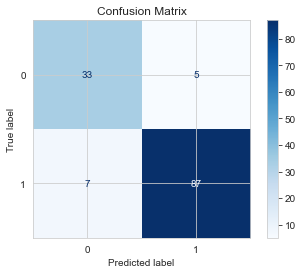

In [35]:
# ----------------------------------------------------------
# IMPORTS
# ----------------------------------------------------------
import math, optuna, mlflow, xgboost as xgb, tempfile, shutil
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score, log_loss, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
try:
    from mlflow.models.signature import infer_signature   # MLflow ≤ 3.1
except ImportError:
    from mlflow.models import infer_signature             # MLflow ≥ 3.2

# ----------------------------------------------------------
# PREPARE DATA (assume X, y prontos)
# ----------------------------------------------------------
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.3, random_state=123)
X_train, X_valid, y_train, y_valid = train_test_split(X_trainval, y_trainval, test_size=0.2, random_state=123)

# ----------------------------------------------------------
# FUNÇÃO DE OTIMIZAÇÃO (usa apenas treino+validação)
# ----------------------------------------------------------
def optimize_hyperparameters(trial):
    # Subtreinamento para evitar overfitting
    dsubtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_valid, label=y_valid)

    # Hiperparâmetros
    params = {
        "objective": "binary:logistic",
        "eval_metric": "logloss",
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
    }

    with mlflow.start_run(nested=True):
        # Treinamento com early stopping
        model = xgb.train(
            params,
            dsubtrain,
            evals=[(dvalid, "validation")],
            num_boost_round=1000,
            early_stopping_rounds=20,
            verbose_eval=False
        )

        # Predição na validação
        preds_proba = model.predict(dvalid)
        preds = (preds_proba >= 0.5).astype(int)

        # Métrica
        f1 = f1_score(y_valid, preds)

        # Loga no MLflow
        mlflow.log_params(params)
        mlflow.log_metric("f1_score", f1)

    return 1.0 - f1  # Porque o Optuna minimiza

# ----------------------------------------------------------
# CALLBACK PARA FEEDBACK
# ----------------------------------------------------------
def f1_score_callback(study, frozen_trial):
    current_winner = study.user_attrs.get("winner", None)
    if study.best_value and current_winner != study.best_value:
        study.set_user_attr("winner", study.best_value)
        print(f"🟢 Novo melhor f1-score: {1.0 - study.best_value:.4f} no trial {frozen_trial.number}")

# ----------------------------------------------------------
# EXPERIMENTO
# ----------------------------------------------------------
run_name = "experiment_1"
mlflow.set_experiment(experiment_id=id_experiment)

with mlflow.start_run(run_name=run_name):

    # 1) Otimização com Optuna
    study = optuna.create_study(direction="minimize")
    study.optimize(optimize_hyperparameters, n_trials=100, callbacks=[f1_score_callback])

    # 2) Treino final com os melhores parâmetros usando train+val
    dtrainval = xgb.DMatrix(X_trainval, label=y_trainval)
    dtest = xgb.DMatrix(X_test, label=y_test)

    final_model = xgb.train(
        study.best_params,
        dtrainval,
        evals=[(dtest, "test")],
        num_boost_round=1000,
        early_stopping_rounds=20,
        verbose_eval=False
    )

    # 3) Avaliação no conjunto de teste (final!)
    y_pred_test = final_model.predict(dtest)
    y_pred_binary = (y_pred_test >= 0.5).astype(int)

    acc = accuracy_score(y_test, y_pred_binary)
    prec = precision_score(y_test, y_pred_binary)
    rec = recall_score(y_test, y_pred_binary)
    f1 = f1_score(y_test, y_pred_binary)

    mlflow.log_metric("final_accuracy", acc)
    mlflow.log_metric("final_precision", prec)
    mlflow.log_metric("final_recall", rec)
    mlflow.log_metric("final_f1_score", f1)

    # 4) Log figuras
    cm = confusion_matrix(y_test, y_pred_binary)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix")
    fig_path = "confusion_matrix.png"
    plt.savefig(fig_path)
    mlflow.log_artifact(fig_path)

    # 5) Assinatura
    signature = infer_signature(X_trainval, final_model.predict(dtrainval))

    # 6) Salva modelo
    tmp_dir = tempfile.mkdtemp()
    model_save_path = f"{tmp_dir}/model"

    mlflow.xgboost.save_model(
        final_model,
        path=model_save_path,
        input_example=X_trainval.iloc[[0]],
        signature=signature,
        model_format="ubj",
        metadata={"model_data_version": 1}
    )
    mlflow.log_artifacts(model_save_path, artifact_path="model")
    shutil.rmtree(tmp_dir)

print("✅ Finalizado. Modelo avaliado corretamente em X_test.")


In [36]:
client = MlflowClient()

# Filtra exatamente o run pelo nome
papa = client.search_runs(
    experiment_ids=[id_experiment],
    filter_string='tag.mlflow.runName = "experiment_1"')[0]   # pega o primeiro (deve ser só 1)

run_id_pai = papa.info.run_id
print("RUN pai  :", run_id_pai)
print("URI base :", papa.info.artifact_uri)   # ← URI absoluta exibida na UI

RUN pai  : d0d1949c04024484adac9564597d46d5
URI base : mlflow-artifacts:/417319430413877898/d0d1949c04024484adac9564597d46d5/artifacts


In [37]:
model_uri = f"runs:/{run_id_pai}/model"

# Forma absoluta (equivalente, se preferir copiar/colar da UI)
model_uri_abs = f"{papa.info.artifact_uri}/model/"
model_uri_abs


'mlflow-artifacts:/417319430413877898/d0d1949c04024484adac9564597d46d5/artifacts/model/'

In [29]:
import mlflow.xgboost
booster = mlflow.xgboost.load_model(model_uri_abs)   # ou model_uri_abs

# Confere hiperparâmetros (flatten_last)
import json
def flatten_last(d):
    out, stack = {}, [d]
    while stack:
        cur = stack.pop()
        for k, v in cur.items():
            if isinstance(v, dict):
                stack.append(v)
            else:
                out[k] = v          # mantém o último (real)
    return out

flat = flatten_last(json.loads(booster.save_config())["learner"])
for p in ["booster", "max_depth", "eta", "gamma", "reg_lambda", "reg_alpha", "grow_policy"]:
    print(f"{p:11}: {flat.get(p)}")

booster    : dart
max_depth  : 6
eta        : 0.300000012
gamma      : 0
reg_lambda : 1
reg_alpha  : 0
grow_policy: depthwise


In [31]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

melhor_modelo = mlflow.xgboost.load_model(model_uri)

Acurácia  : 0.909
Precisão  : 0.946
Revocação : 0.926
F1-score  : 0.935


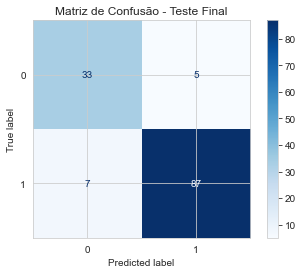

In [38]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import mlflow.xgboost
import xgboost as xgb
import matplotlib.pyplot as plt

# ⚠️ Não redivida os dados!
# X_train, X_test, ... já foram definidos antes e X_test deve ser o mesmo da divisão original

# Converte X_test para DMatrix
dtest = xgb.DMatrix(X_test)

# Carrega o modelo treinado
melhor_modelo = mlflow.xgboost.load_model(model_uri)

# Faz predições (probabilidades)
y_prob = melhor_modelo.predict(dtest)

# Aplica threshold de 0.5 para obter classes binárias
y_pred = (y_prob > 0.5).astype(int)

# Calcula as métricas
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Exibe os resultados
print(f'Acurácia  : {acc:.3f}')
print(f'Precisão  : {prec:.3f}')
print(f'Revocação : {rec:.3f}')
print(f'F1-score  : {f1:.3f}')

# Matriz de confusão
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Matriz de Confusão - Teste Final")
plt.show()
